# 1 vị trí riêng lẻ - dashboard

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [1]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from micromlgen import port

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "dashboard"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: dashboard
   → #IMU channels (không tính speed): 6
   → Tổng số kênh (đã gồm speed):      7


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [2]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [3]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: dashboard) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [4]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [5]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [6]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [7]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(80, dtype=np.float32)
    
#     # ---- DASHBOARD ----
#     ax_dashboard = np.array(at['acc_x_dashboard'],  dtype=np.float32)
#     ay_dashboard = np.array(at['acc_y_dashboard'],  dtype=np.float32)
#     az_dashboard = np.array(at['acc_z_dashboard'],  dtype=np.float32)
#     gx_dashboard = np.array(at['gyro_x_dashboard'], dtype=np.float32)
#     gy_dashboard = np.array(at['gyro_y_dashboard'], dtype=np.float32)
#     gz_dashboard = np.array(at['gyro_z_dashboard'], dtype=np.float32)
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê    
#     feat[0:7] = [np.mean(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard, sp]] # mean
#     feat[7:14] = [np.std(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard, sp]] # sd
#     feat[14:20] = [np.sqrt(np.mean(i**2)) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # rms
#     feat[20:26] = [np.max(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # max
#     feat[26:32] = [np.min(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # min
#     feat[32:38] = [np.amax(i) - np.amin(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # range
#     feat[38:44] = [np.median(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # median
#     feat[44:50] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # interquartile range
#     feat[50:56] = [skew(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # skewness
#     feat[56:62] = [kurtosis(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # kurtosis
#     feat[62:68] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # hjorth mobility
#     feat[68:74] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # hjorth complexity
#     feat[74:80] = [acf(i, nlags=1)[1] for i in [ax_dashboard, ay_dashboard, az_dashboard, gx_dashboard, gy_dashboard, gz_dashboard]] # autocorrelation
    
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [8]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [9]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 80
ALL PVS: (7180, 80) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_dashboard.npz'


## Cell 8 — Find candidates

In [10]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(25, 26)),
        "max_depth": list(range(9, 10))
    },
    "E2": {
        "n_estimators": list(range(33, 34)),
        "max_depth": list(range(8, 9))
    },
    "E3": {
        "n_estimators": list(range(28, 29)),
        "max_depth": list(range(8, 9))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train RandomForestClassifier trên toàn bộ dữ liệu (PVS 1–9) với 'params',
    export C/C++ header bằng micromlgen.port() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code) — c_code chỉ để xem nhanh; không lưu file chính thức ở đây.
    """
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_json = None
    header_tmp = "tmp_model_header.h"
    c_code = None
    err = ""
    size_mb = None
    try:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False, encoding="utf-8") as tmp:
            tmp_json = tmp.name
            pass
        c_code = port(clf, tmp_file=tmp_json)
        with open(header_tmp, "w", encoding="utf-8") as f:
            f.write(c_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_json and os.path.exists(tmp_json):
            os.remove(tmp_json)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)
            
    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_RF.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_RF.json'.")


✅ Using preset: dashboard

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E1] Check 1/1: {'max_depth': 9, 'n_estimators': 25} | CV Accuracy=86.24
   -> size=0.989 MB | status=ok
[E1] BEST CANDIDATE: {'exp': 'E1', 'params': {'max_depth': 9, 'n_estimators': 25}, 'cv_accuracy': 0.8624218070595684, 'size_mb': 0.9892082214355469}

===== EXP E2: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E2] Check 1/1: {'max_depth': 8, 'n_estimators': 33} | CV Accuracy=89.21
   -> size=0.952 MB | status=ok
[E2] BEST CANDIDATE: {'exp': 'E2', 'params': {'max_depth': 8, 'n_estimators': 33}, 'cv_accuracy': 0.8920878465963287, 'size_mb': 0.9516897201538086}

===== EXP E3: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E3] Check 1/1: {'max_depth': 8, 'n_estimators': 28} | CV Accuracy=86.39
   -> size=0.801 MB | status=ok
[E3] BEST CANDIDATE: {'exp': 'E3', 'params': {'max_depth': 8, 'n_estimators': 28}, 'cv_accuracy': 0.86387155211355, 'size_mb': 0.8008213043212891}



In [11]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 9, 'n_estimators': 25}, 'cv_accuracy': 0.8624, 'size_mb': 0.989} -> 84.28
# {'exp': 'E2', 'params': {'max_depth': 8, 'n_estimators': 33}, 'cv_accuracy': 0.8920, 'size_mb': 0.951} -> 82.68 Maximin, Borda rank, Minimax regret, Mean - λ·Std
# {'exp': 'E3', 'params': {'max_depth': 8, 'n_estimators': 28}, 'cv_accuracy': 0.8638, 'size_mb': 0.800} -> 82.72


## Cell 9 — Select candidates

In [12]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_RF.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = RandomForestClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 9, 'n_estimators': 25}
   E1: Accuracy(LOGO) = 86.24
   E2: Accuracy(LOGO) = 88.91
   E3: Accuracy(LOGO) = 85.18

>>> Scoring cand_E2 with params={'max_depth': 8, 'n_estimators': 33}
   E1: Accuracy(LOGO) = 85.43
   E2: Accuracy(LOGO) = 89.21
   E3: Accuracy(LOGO) = 86.05

>>> Scoring cand_E3 with params={'max_depth': 8, 'n_estimators': 28}
   E1: Accuracy(LOGO) = 84.97
   E2: Accuracy(LOGO) = 89.01
   E3: Accuracy(LOGO) = 86.39

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand_E1', 'params': {'max_depth': 9, 'n_estimators': 25}, 'size_mb': 0.989, 'S_E1': np.float64(86.24), 'S_E2': np.float64(88.91), 'S_E3': np.float64(85.18), 'mean': np.float64(86.78), 'std': np.float64(0.02)}
{'name': 'cand_E2', 'params': {'max_depth': 8, 'n_estimators': 33}, 'size_mb': 0.952, 'S_E1': np.float64(85.43), 'S_E2': np.float64(89.21), 'S_E3': np.float64(86.05), 'mean': np.float64(86.9), 'std': np.float64(0.02)}
{'name': 'cand_E3', 'params':

## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [13]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 8, "n_estimators": 33}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
Training   -> Acc =  94.53
Validation -> Acc =  81.57

===== Evaluation on E2 =====
Training   -> Acc =  97.57
Validation -> Acc =  80.27

===== Evaluation on E3 =====
Training   -> Acc =  97.04
Validation -> Acc =  86.18

===== FINAL SUMMARY =====
[Training]    Accuracy    : 96.38 ± 1.33
[Validation]  Accuracy    : 82.68 ± 2.53


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[CM] Refit & predict on E2
[CM] Refit & predict on E3


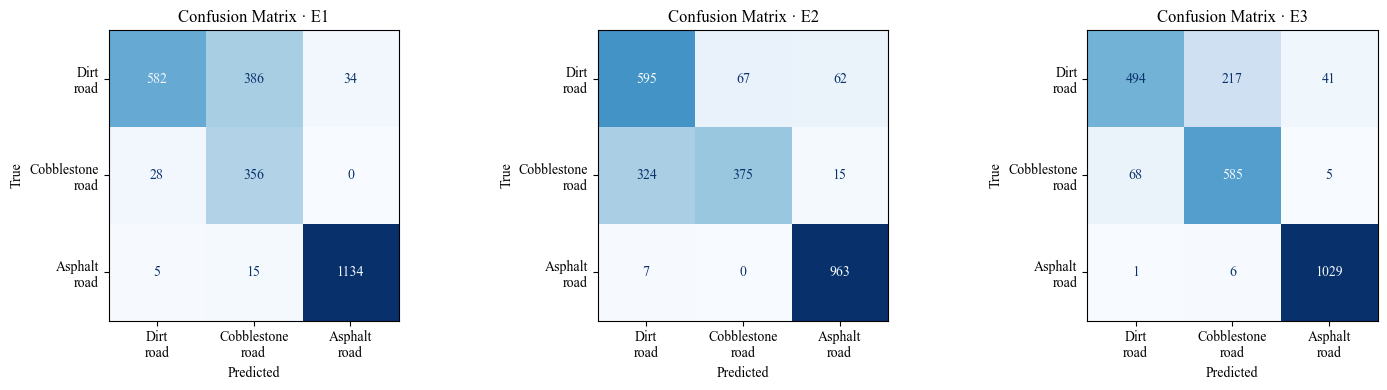

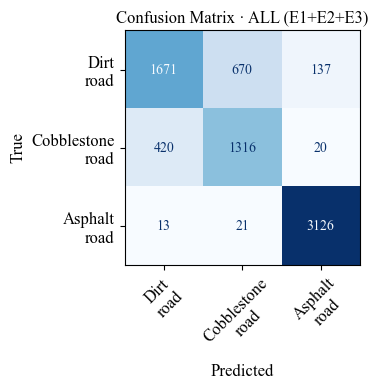

In [14]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [15]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.7942    0.6743    0.7294      2478
Cobblestone road     0.6557    0.7494    0.6994      1756
    Asphalt road     0.9522    0.9892    0.9704      3160

        accuracy                         0.8268      7394
       macro avg     0.8007    0.8043    0.7997      7394
    weighted avg     0.8288    0.8268    0.8253      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [16]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_RF = RandomForestClassifier(**BEST_PARAMS, random_state=42)
final_clf_RF.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_PVS_RF.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_RF, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_PVS_RF.h'
📦 Header size: 974.53 KB (0.952 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmpr_gt42sr.json


# 1 vị trí riêng lẻ - above

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [17]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from micromlgen import port

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "above"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: above
   → #IMU channels (không tính speed): 6
   → Tổng số kênh (đã gồm speed):      7


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [18]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [19]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: above) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [20]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [21]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [22]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [23]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(80, dtype=np.float32)
    
#     # ---- ABOVE ----
#     ax_above = np.array(at['acc_x_above_suspension'],  dtype=np.float32)
#     ay_above = np.array(at['acc_y_above_suspension'],  dtype=np.float32)
#     az_above = np.array(at['acc_z_above_suspension'],  dtype=np.float32)
#     gx_above = np.array(at['gyro_x_above_suspension'], dtype=np.float32)
#     gy_above = np.array(at['gyro_y_above_suspension'], dtype=np.float32)
#     gz_above = np.array(at['gyro_z_above_suspension'], dtype=np.float32)
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê
#     feat[0:7] = [np.mean(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above, sp]] # mean
#     feat[7:14] = [np.std(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above, sp]] # sd
#     feat[14:20] = [np.sqrt(np.mean(i**2)) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # rms
#     feat[20:26] = [np.max(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # max
#     feat[26:32] = [np.min(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # min
#     feat[32:38] = [np.amax(i) - np.amin(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # range
#     feat[38:44] = [np.median(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # median
#     feat[44:50] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # interquartile range
#     feat[50:56] = [skew(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # skewness
#     feat[56:62] = [kurtosis(i) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # kurtosis
#     feat[62:68] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # hjorth mobility
#     feat[68:74] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # hjorth complexity
#     feat[74:80] = [acf(i, nlags=1)[1] for i in [ax_above, ay_above, az_above, gx_above, gy_above, gz_above]] # autocorrelation
    
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [24]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [25]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 80
ALL PVS: (7180, 80) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_above.npz'


## Cell 8 — Find candidates

In [26]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(12, 13)),
        "max_depth": list(range(11, 13))
    },
    "E2": {
        "n_estimators": list(range(27, 28)),
        "max_depth": list(range(8, 9))
    },
    "E3": {
        "n_estimators": list(range(18, 19)),
        "max_depth": list(range(9, 10))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train RandomForestClassifier trên toàn bộ dữ liệu (PVS 1–9) với 'params',
    export C/C++ header bằng micromlgen.port() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code) — c_code chỉ để xem nhanh; không lưu file chính thức ở đây.
    """
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_json = None
    header_tmp = "tmp_model_header.h"
    c_code = None
    err = ""
    size_mb = None
    try:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False, encoding="utf-8") as tmp:
            tmp_json = tmp.name
            pass
        c_code = port(clf, tmp_file=tmp_json)
        with open(header_tmp, "w", encoding="utf-8") as f:
            f.write(c_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_json and os.path.exists(tmp_json):
            os.remove(tmp_json)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)
            
    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_RF.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_RF.json'.")


✅ Using preset: above

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E1] Check 1/2: {'max_depth': 11, 'n_estimators': 12} | CV Accuracy=85.05
   -> size=0.968 MB | status=ok
[E1] Check 2/2: {'max_depth': 12, 'n_estimators': 12} | CV Accuracy=84.42
   -> size=1.169 MB | status=oversize
[E1] BEST CANDIDATE: {'exp': 'E1', 'params': {'max_depth': 11, 'n_estimators': 12}, 'cv_accuracy': 0.850548548421858, 'size_mb': 0.968317985534668}

===== EXP E2: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E2] Check 1/1: {'max_depth': 8, 'n_estimators': 27} | CV Accuracy=86.57
   -> size=0.908 MB | status=ok
[E2] BEST CANDIDATE: {'exp': 'E2', 'params': {'max_depth': 8, 'n_estimators': 27}, 'cv_accuracy': 0.8657359028361545, 'size_mb': 0.9080686569213867}

===== EXP E3: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E3] Check 1/1: {'max_depth': 9, 'n_estimators': 18} | CV Accuracy=85.29
   -> size=0.789 MB | status=ok
[E3] BEST CANDIDATE: {'exp': 'E3', 'para

In [27]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 11, 'n_estimators': 12}, 'cv_accuracy': 0.8505, 'size_mb': 0.968} -> 86.96
# {'exp': 'E2', 'params': {'max_depth': 08, 'n_estimators': 27}, 'cv_accuracy': 0.8657, 'size_mb': 0.908} -> 87.62 Borda rank, Minimax regret
# {'exp': 'E3', 'params': {'max_depth': 09, 'n_estimators': 18}, 'cv_accuracy': 0.8528, 'size_mb': 0.788} -> 88.28 Maximin, Mean - λ·Std

## Cell 9 — Select candidates

In [28]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_RF.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = RandomForestClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 11, 'n_estimators': 12}
   E1: Accuracy(LOGO) = 85.05
   E2: Accuracy(LOGO) = 85.72
   E3: Accuracy(LOGO) = 84.15

>>> Scoring cand_E2 with params={'max_depth': 8, 'n_estimators': 27}
   E1: Accuracy(LOGO) = 84.39
   E2: Accuracy(LOGO) = 86.57
   E3: Accuracy(LOGO) = 84.17

>>> Scoring cand_E3 with params={'max_depth': 9, 'n_estimators': 18}
   E1: Accuracy(LOGO) = 84.36
   E2: Accuracy(LOGO) = 85.37
   E3: Accuracy(LOGO) = 85.29

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand_E1', 'params': {'max_depth': 11, 'n_estimators': 12}, 'size_mb': 0.968, 'S_E1': np.float64(85.05), 'S_E2': np.float64(85.72), 'S_E3': np.float64(84.15), 'mean': np.float64(84.97), 'std': np.float64(0.01)}
{'name': 'cand_E2', 'params': {'max_depth': 8, 'n_estimators': 27}, 'size_mb': 0.908, 'S_E1': np.float64(84.39), 'S_E2': np.float64(86.57), 'S_E3': np.float64(84.17), 'mean': np.float64(85.05), 'std': np.float64(0.01)}
{'name': 'cand_E3', 'param

## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [29]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 8, "n_estimators": 27}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
Training   -> Acc =  94.63
Validation -> Acc =  84.65

===== Evaluation on E2 =====
Training   -> Acc =  97.38
Validation -> Acc =  89.00

===== Evaluation on E3 =====
Training   -> Acc =  96.45
Validation -> Acc =  89.21

===== FINAL SUMMARY =====
[Training]    Accuracy    : 96.16 ± 1.14
[Validation]  Accuracy    : 87.62 ± 2.10


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[CM] Refit & predict on E2
[CM] Refit & predict on E3


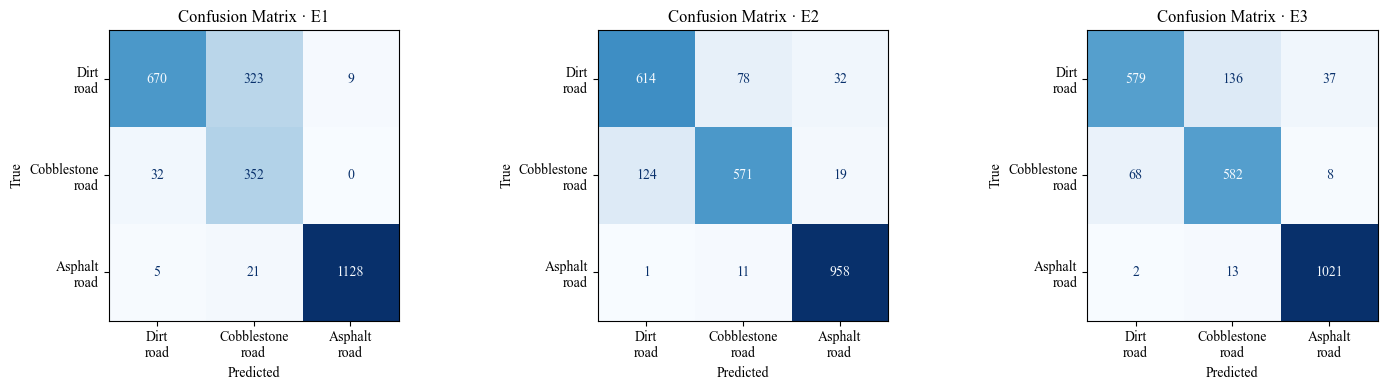

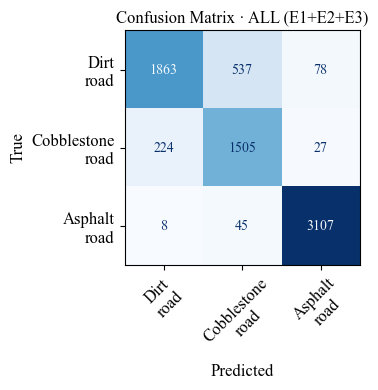

In [30]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [31]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8893    0.7518    0.8148      2478
Cobblestone road     0.7211    0.8571    0.7832      1756
    Asphalt road     0.9673    0.9832    0.9752      3160

        accuracy                         0.8757      7394
       macro avg     0.8592    0.8640    0.8577      7394
    weighted avg     0.8827    0.8757    0.8759      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [32]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_RF = RandomForestClassifier(**BEST_PARAMS, random_state=42)
final_clf_RF.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_PVS_RF.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_RF, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_PVS_RF.h'
📦 Header size: 929.86 KB (0.908 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmpw0_ptf9l.json


# 1 vị trí riêng lẻ - below

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [33]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from micromlgen import port

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "below"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: below
   → #IMU channels (không tính speed): 6
   → Tổng số kênh (đã gồm speed):      7


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [34]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [35]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: below) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [36]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [37]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [38]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [39]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(80, dtype=np.float32)
    
#     # ---- BELOW ----
#     ax_below = np.array(at['acc_x_below_suspension'],  dtype=np.float32)
#     ay_below = np.array(at['acc_y_below_suspension'],  dtype=np.float32)
#     az_below = np.array(at['acc_z_below_suspension'],  dtype=np.float32)
#     gx_below = np.array(at['gyro_x_below_suspension'], dtype=np.float32)
#     gy_below = np.array(at['gyro_y_below_suspension'], dtype=np.float32)
#     gz_below = np.array(at['gyro_z_below_suspension'], dtype=np.float32)    
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê    
#     feat[0:7] = [np.mean(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below, sp]] # mean
#     feat[7:14] = [np.std(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below, sp]] # sd
#     feat[14:20] = [np.sqrt(np.mean(i**2)) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # rms
#     feat[20:26] = [np.max(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # max
#     feat[26:32] = [np.min(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # min
#     feat[32:38] = [np.amax(i) - np.amin(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # range
#     feat[38:44] = [np.median(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # median
#     feat[44:50] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # interquartile range
#     feat[50:56] = [skew(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # skewness
#     feat[56:62] = [kurtosis(i) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # kurtosis
#     feat[62:68] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # hjorth mobility
#     feat[68:74] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # hjorth complexity
#     feat[74:80] = [acf(i, nlags=1)[1] for i in [ax_below, ay_below, az_below, gx_below, gy_below, gz_below]] # autocorrelation
    
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [40]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [41]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 80
ALL PVS: (7180, 80) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_below.npz'


## Cell 8 — Find candidates

In [42]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(24, 25)),
        "max_depth": list(range(8, 9))
    },
    "E2": {
        "n_estimators": list(range(16, 17)),
        "max_depth": list(range(10, 12))
    },
    "E3": {
        "n_estimators": list(range(21, 22)),
        "max_depth": list(range(9, 10))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train RandomForestClassifier trên toàn bộ dữ liệu (PVS 1–9) với 'params',
    export C/C++ header bằng micromlgen.port() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code) — c_code chỉ để xem nhanh; không lưu file chính thức ở đây.
    """
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_json = None
    header_tmp = "tmp_model_header.h"
    c_code = None
    err = ""
    size_mb = None
    try:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False, encoding="utf-8") as tmp:
            tmp_json = tmp.name
            pass
        c_code = port(clf, tmp_file=tmp_json)
        with open(header_tmp, "w", encoding="utf-8") as f:
            f.write(c_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_json and os.path.exists(tmp_json):
            os.remove(tmp_json)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)
            
    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_RF.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_RF.json'.")


✅ Using preset: below

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E1] Check 1/1: {'max_depth': 8, 'n_estimators': 24} | CV Accuracy=85.41
   -> size=0.772 MB | status=ok
[E1] BEST CANDIDATE: {'exp': 'E1', 'params': {'max_depth': 8, 'n_estimators': 24}, 'cv_accuracy': 0.8540537170553822, 'size_mb': 0.7722816467285156}

===== EXP E2: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E2] Check 1/2: {'max_depth': 10, 'n_estimators': 16} | CV Accuracy=88.43
   -> size=0.989 MB | status=ok
[E2] Check 2/2: {'max_depth': 11, 'n_estimators': 16} | CV Accuracy=86.78
   -> size=1.292 MB | status=oversize
[E2] BEST CANDIDATE: {'exp': 'E2', 'params': {'max_depth': 10, 'n_estimators': 16}, 'cv_accuracy': 0.8843436855626172, 'size_mb': 0.9892921447753906}

===== EXP E3: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E3] Check 1/1: {'max_depth': 9, 'n_estimators': 21} | CV Accuracy=85.71
   -> size=0.993 MB | status=ok
[E3] BEST CANDIDATE: {'exp': 'E3', 'pa

In [43]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 08, 'n_estimators': 24}, 'cv_accuracy': 0.8540, 'size_mb': 0.772} -> 87.29 Maximin, Borda rank
# {'exp': 'E2', 'params': {'max_depth': 10, 'n_estimators': 16}, 'cv_accuracy': 0.8843, 'size_mb': 0.989} -> 88.06
# {'exp': 'E3', 'params': {'max_depth': 09, 'n_estimators': 21}, 'cv_accuracy': 0.8571, 'size_mb': 0.993} -> 88.15 Minimax regret, Mean - λ·Std

## Cell 9 — Select candidates

In [44]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_RF.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = RandomForestClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 8, 'n_estimators': 24}
   E1: Accuracy(LOGO) = 85.41
   E2: Accuracy(LOGO) = 87.59
   E3: Accuracy(LOGO) = 84.83

>>> Scoring cand_E2 with params={'max_depth': 10, 'n_estimators': 16}
   E1: Accuracy(LOGO) = 84.86
   E2: Accuracy(LOGO) = 88.43
   E3: Accuracy(LOGO) = 83.94

>>> Scoring cand_E3 with params={'max_depth': 9, 'n_estimators': 21}
   E1: Accuracy(LOGO) = 84.76
   E2: Accuracy(LOGO) = 87.65
   E3: Accuracy(LOGO) = 85.71

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand_E1', 'params': {'max_depth': 8, 'n_estimators': 24}, 'size_mb': 0.772, 'S_E1': np.float64(85.41), 'S_E2': np.float64(87.59), 'S_E3': np.float64(84.83), 'mean': np.float64(85.94), 'std': np.float64(0.01)}
{'name': 'cand_E2', 'params': {'max_depth': 10, 'n_estimators': 16}, 'size_mb': 0.989, 'S_E1': np.float64(84.86), 'S_E2': np.float64(88.43), 'S_E3': np.float64(83.94), 'mean': np.float64(85.75), 'std': np.float64(0.02)}
{'name': 'cand_E3', 'param

## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [45]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 8, "n_estimators": 24}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
Training   -> Acc =  96.21
Validation -> Acc =  85.04

===== Evaluation on E2 =====
Training   -> Acc =  97.51
Validation -> Acc =  87.96

===== Evaluation on E3 =====
Training   -> Acc =  97.72
Validation -> Acc =  88.88

===== FINAL SUMMARY =====
[Training]    Accuracy    : 97.14 ± 0.67
[Validation]  Accuracy    : 87.29 ± 1.64


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[CM] Refit & predict on E2
[CM] Refit & predict on E3


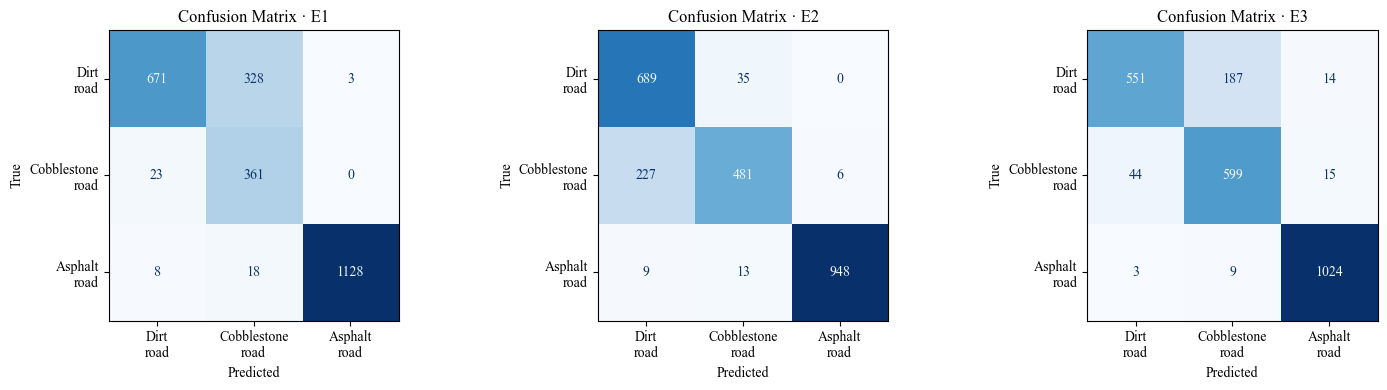

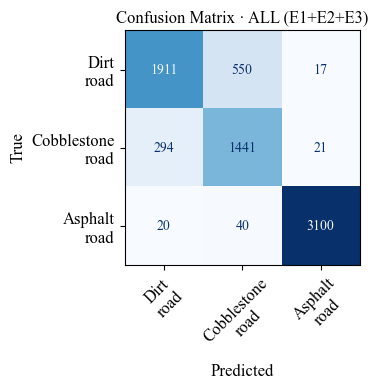

In [46]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [47]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8589    0.7712    0.8127      2478
Cobblestone road     0.7095    0.8206    0.7610      1756
    Asphalt road     0.9879    0.9810    0.9844      3160

        accuracy                         0.8726      7394
       macro avg     0.8521    0.8576    0.8527      7394
    weighted avg     0.8785    0.8726    0.8738      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [48]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_RF = RandomForestClassifier(**BEST_PARAMS, random_state=42)
final_clf_RF.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_PVS_RF.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_RF, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_PVS_RF.h'
📦 Header size: 790.82 KB (0.772 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmpb73suhdw.json


# 2 vị trí kết hợp - dashboard + above

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [49]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from micromlgen import port

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "dashboard+above"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: dashboard+above
   → #IMU channels (không tính speed): 12
   → Tổng số kênh (đã gồm speed):      13


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [50]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [51]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: dashboard+above) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [52]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [53]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [54]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [55]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(158, dtype=np.float32)
    
#     # ---- DASHBOARD ----
#     ax_dashboard = np.array(at['acc_x_dashboard'],  dtype=np.float32)
#     ay_dashboard = np.array(at['acc_y_dashboard'],  dtype=np.float32)
#     az_dashboard = np.array(at['acc_z_dashboard'],  dtype=np.float32)
#     gx_dashboard = np.array(at['gyro_x_dashboard'], dtype=np.float32)
#     gy_dashboard = np.array(at['gyro_y_dashboard'], dtype=np.float32)
#     gz_dashboard = np.array(at['gyro_z_dashboard'], dtype=np.float32)
    
#     # ---- ABOVE ----
#     ax_above = np.array(at['acc_x_above_suspension'],  dtype=np.float32)
#     ay_above = np.array(at['acc_y_above_suspension'],  dtype=np.float32)
#     az_above = np.array(at['acc_z_above_suspension'],  dtype=np.float32)
#     gx_above = np.array(at['gyro_x_above_suspension'], dtype=np.float32)
#     gy_above = np.array(at['gyro_y_above_suspension'], dtype=np.float32)
#     gz_above = np.array(at['gyro_z_above_suspension'], dtype=np.float32)
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê
#     feat[0:13] = [np.mean(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above,
#                                        sp]] # mean
#     feat[13:26] = [np.std(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above,
#                                        sp]] # sd
#     feat[26:38] = [np.sqrt(np.mean(i**2)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                     gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # rms
#     feat[38:50] = [np.max(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # max
#     feat[50:62] = [np.min(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # min
#     feat[62:74] = [np.amax(i) - np.amin(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # range
#     feat[74:86] = [np.median(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                           gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # median
#     feat[86:98] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                                          gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # interquartile range
#     feat[98:110] = [skew(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                       gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # skewness
#     feat[110:122] = [kurtosis(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                            gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # kurtosis
#     feat[122:134] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # hjorth mobility
#     feat[134:146] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                                                                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # hjorth complexity
#     feat[146:158] = [acf(i, nlags=1)[1] for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above,
#                                                   gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above]] # autocorrelation
        
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [56]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [57]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 158
ALL PVS: (7180, 158) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_dashboard+above.npz'


## Cell 8 — Find candidates

In [58]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(21, 22)),
        "max_depth": list(range(9, 10))
    },
    "E2": {
        "n_estimators": list(range(23, 24)),
        "max_depth": list(range(9, 10))
    },
    "E3": {
        "n_estimators": list(range(31, 32)),
        "max_depth": list(range(8, 9))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train RandomForestClassifier trên toàn bộ dữ liệu (PVS 1–9) với 'params',
    export C/C++ header bằng micromlgen.port() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code) — c_code chỉ để xem nhanh; không lưu file chính thức ở đây.
    """
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_json = None
    header_tmp = "tmp_model_header.h"
    c_code = None
    err = ""
    size_mb = None
    try:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False, encoding="utf-8") as tmp:
            tmp_json = tmp.name
            pass
        c_code = port(clf, tmp_file=tmp_json)
        with open(header_tmp, "w", encoding="utf-8") as f:
            f.write(c_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_json and os.path.exists(tmp_json):
            os.remove(tmp_json)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)
            
    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_RF.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_RF.json'.")


✅ Using preset: dashboard+above

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[E1] Check 1/1: {'max_depth': 9, 'n_estimators': 21} | CV Accuracy=85.46
   -> size=0.915 MB | status=ok
[E1] BEST CANDIDATE: {'exp': 'E1', 'params': {'max_depth': 9, 'n_estimators': 21}, 'cv_accuracy': 0.8546258367253389, 'size_mb': 0.9150228500366211}

===== EXP E2: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E2] Check 1/1: {'max_depth': 9, 'n_estimators': 23} | CV Accuracy=88.52
   -> size=0.998 MB | status=ok
[E2] BEST CANDIDATE: {'exp': 'E2', 'params': {'max_depth': 9, 'n_estimators': 23}, 'cv_accuracy': 0.8851590478674152, 'size_mb': 0.9977483749389648}

===== EXP E3: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E3] Check 1/1: {'max_depth': 8, 'n_estimators': 31} | CV Accuracy=86.35
   -> size=0.935 MB | status=ok
[E3] BEST CANDIDATE: {'exp': 'E3', 'params': {'max_depth': 8, 'n_estimators': 31}, 'cv_accuracy': 0.86350417537273, 'size_mb': 0.9351491928100586}

===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====
{'exp': 'E1', 'params': {'max_depth': 9, 'n_e

In [59]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 9, 'n_estimators': 21}, 'cv_accuracy': 0.8546, 'size_mb': 0.915} -> 87.78 Maximin
# {'exp': 'E2', 'params': {'max_depth': 9, 'n_estimators': 23}, 'cv_accuracy': 0.8851, 'size_mb': 0.997} -> 87.83 Borda rank
# {'exp': 'E3', 'params': {'max_depth': 8, 'n_estimators': 31}, 'cv_accuracy': 0.8635, 'size_mb': 0.935} -> 87.34 Minimax regret, Mean - λ·Std

## Cell 9 — Select candidates

In [60]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_RF.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = RandomForestClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 9, 'n_estimators': 21}
   E1: Accuracy(LOGO) = 85.46
   E2: Accuracy(LOGO) = 88.15
   E3: Accuracy(LOGO) = 85.48

>>> Scoring cand_E2 with params={'max_depth': 9, 'n_estimators': 23}
   E1: Accuracy(LOGO) = 85.44
   E2: Accuracy(LOGO) = 88.52
   E3: Accuracy(LOGO) = 85.86

>>> Scoring cand_E3 with params={'max_depth': 8, 'n_estimators': 31}
   E1: Accuracy(LOGO) = 85.28
   E2: Accuracy(LOGO) = 88.34
   E3: Accuracy(LOGO) = 86.35

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand_E1', 'params': {'max_depth': 9, 'n_estimators': 21}, 'size_mb': 0.915, 'S_E1': np.float64(85.46), 'S_E2': np.float64(88.15), 'S_E3': np.float64(85.48), 'mean': np.float64(86.37), 'std': np.float64(0.01)}
{'name': 'cand_E2', 'params': {'max_depth': 9, 'n_estimators': 23}, 'size_mb': 0.998, 'S_E1': np.float64(85.44), 'S_E2': np.float64(88.52), 'S_E3': np.float64(85.86), 'mean': np.float64(86.61), 'std': np.float64(0.01)}
{'name': 'cand_E3', 'params'

## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [61]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 8, "n_estimators": 31}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
Training   -> Acc =  96.23
Validation -> Acc =  87.80

===== Evaluation on E2 =====
Training   -> Acc =  98.05
Validation -> Acc =  84.80

===== Evaluation on E3 =====
Training   -> Acc =  97.68
Validation -> Acc =  89.41

===== FINAL SUMMARY =====
[Training]    Accuracy    : 97.32 ± 0.79
[Validation]  Accuracy    : 87.34 ± 1.91


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[CM] Refit & predict on E2
[CM] Refit & predict on E3


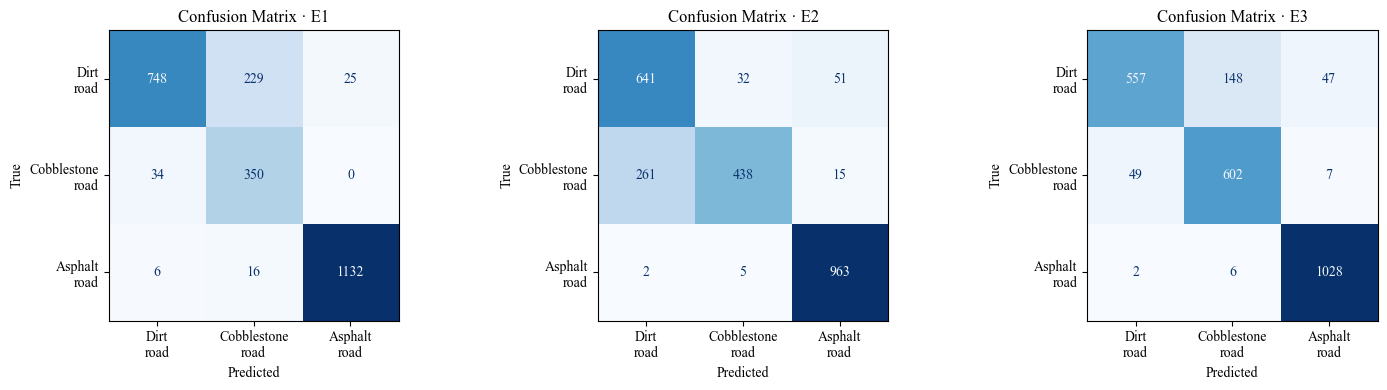

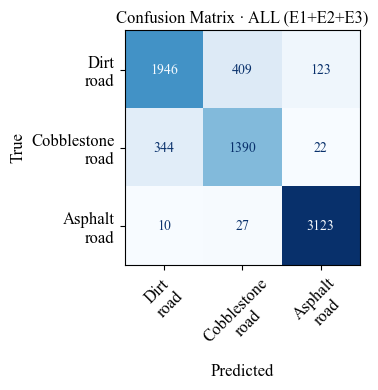

In [62]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [63]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8461    0.7853    0.8146      2478
Cobblestone road     0.7612    0.7916    0.7761      1756
    Asphalt road     0.9556    0.9883    0.9717      3160

        accuracy                         0.8735      7394
       macro avg     0.8543    0.8551    0.8541      7394
    weighted avg     0.8727    0.8735    0.8726      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [64]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_RF = RandomForestClassifier(**BEST_PARAMS, random_state=42)
final_clf_RF.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_PVS_RF.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_RF, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_PVS_RF.h'
📦 Header size: 957.59 KB (0.935 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmp51qd41gd.json


# 2 vị trí kết hợp - dashboard + below

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [65]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from micromlgen import port

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "dashboard+below"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: dashboard+below
   → #IMU channels (không tính speed): 12
   → Tổng số kênh (đã gồm speed):      13


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [66]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [67]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: dashboard+below) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [68]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [69]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [70]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [71]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(158, dtype=np.float32)
    
#     # ---- DASHBOARD ----
#     ax_dashboard = np.array(at['acc_x_dashboard'],  dtype=np.float32)
#     ay_dashboard = np.array(at['acc_y_dashboard'],  dtype=np.float32)
#     az_dashboard = np.array(at['acc_z_dashboard'],  dtype=np.float32)
#     gx_dashboard = np.array(at['gyro_x_dashboard'], dtype=np.float32)
#     gy_dashboard = np.array(at['gyro_y_dashboard'], dtype=np.float32)
#     gz_dashboard = np.array(at['gyro_z_dashboard'], dtype=np.float32)
    
#     # ---- BELOW ----
#     ax_below = np.array(at['acc_x_below_suspension'],  dtype=np.float32)
#     ay_below = np.array(at['acc_y_below_suspension'],  dtype=np.float32)
#     az_below = np.array(at['acc_z_below_suspension'],  dtype=np.float32)
#     gx_below = np.array(at['gyro_x_below_suspension'], dtype=np.float32)
#     gy_below = np.array(at['gyro_y_below_suspension'], dtype=np.float32)
#     gz_below = np.array(at['gyro_z_below_suspension'], dtype=np.float32)    
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê    
#     feat[0:13] = [np.mean(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below,
#                                        sp]] # mean
#     feat[13:26] = [np.std(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below,
#                                        sp]] # sd
#     feat[26:38] = [np.sqrt(np.mean(i**2)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                     gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # rms
#     feat[38:50] = [np.max(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # max
#     feat[50:62] = [np.min(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # min
#     feat[62:74] = [np.amax(i) - np.amin(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # range
#     feat[74:86] = [np.median(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                           gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # median
#     feat[86:98] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                                          gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # interquartile range
#     feat[98:110] = [skew(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                       gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # skewness
#     feat[110:122] = [kurtosis(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                            gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # kurtosis
#     feat[122:134] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # hjorth mobility
#     feat[134:146] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                                                                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # hjorth complexity
#     feat[146:158] = [acf(i, nlags=1)[1] for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_below, ay_below, az_below,
#                                                   gx_dashboard, gy_dashboard, gz_dashboard, gx_below, gy_below, gz_below]] # autocorrelation
    
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [72]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [73]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 158
ALL PVS: (7180, 158) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_dashboard+below.npz'


## Cell 8 — Find candidates

In [74]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(15, 16)),
        "max_depth": list(range(10, 12))
    },
    "E2": {
        "n_estimators": list(range(23, 24)),
        "max_depth": list(range(9, 10))
    },
    "E3": {
        "n_estimators": list(range(22, 23)),
        "max_depth": list(range(9, 10))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train RandomForestClassifier trên toàn bộ dữ liệu (PVS 1–9) với 'params',
    export C/C++ header bằng micromlgen.port() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code) — c_code chỉ để xem nhanh; không lưu file chính thức ở đây.
    """
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_json = None
    header_tmp = "tmp_model_header.h"
    c_code = None
    err = ""
    size_mb = None
    try:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False, encoding="utf-8") as tmp:
            tmp_json = tmp.name
            pass
        c_code = port(clf, tmp_file=tmp_json)
        with open(header_tmp, "w", encoding="utf-8") as f:
            f.write(c_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_json and os.path.exists(tmp_json):
            os.remove(tmp_json)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)
            
    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_RF.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_RF.json'.")


✅ Using preset: dashboard+below

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[E1] Check 1/2: {'max_depth': 10, 'n_estimators': 15} | CV Accuracy=86.11
   -> size=0.875 MB | status=ok
[E1] Check 2/2: {'max_depth': 11, 'n_estimators': 15} | CV Accuracy=85.91
   -> size=1.070 MB | status=oversize
[E1] BEST CANDIDATE: {'exp': 'E1', 'params': {'max_depth': 10, 'n_estimators': 15}, 'cv_accuracy': 0.8610539145402157, 'size_mb': 0.8747005462646484}

===== EXP E2: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E2] Check 1/1: {'max_depth': 9, 'n_estimators': 23} | CV Accuracy=89.34
   -> size=0.994 MB | status=ok
[E2] BEST CANDIDATE: {'exp': 'E2', 'params': {'max_depth': 9, 'n_estimators': 23}, 'cv_accuracy': 0.8933851407731316, 'size_mb': 0.9936561584472656}

===== EXP E3: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E3] Check 1/1: {'max_depth': 9, 'n_estimators': 22} | CV Accuracy=86.20
   -> size=0.959 MB | status=ok
[E3] BEST CANDIDATE: {'exp': 'E3', 'params': {'max_depth': 9, 'n_estimators': 22}, 'cv_accuracy': 0.8620040100574488, 'size_mb': 0.

In [75]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 10, 'n_estimators': 15}, 'cv_accuracy': 0.8610, 'size_mb': 0.874} -> 87.29 Maximin
# {'exp': 'E2', 'params': {'max_depth': 09, 'n_estimators': 23}, 'cv_accuracy': 0.8933, 'size_mb': 0.993} -> 88.73 Borda rank, Minimax regret
# {'exp': 'E3', 'params': {'max_depth': 09, 'n_estimators': 22}, 'cv_accuracy': 0.8620, 'size_mb': 0.959} -> 88.30 Mean - λ·Std

## Cell 9 — Select candidates

In [76]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_RF.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = RandomForestClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 10, 'n_estimators': 15}
   E1: Accuracy(LOGO) = 86.11
   E2: Accuracy(LOGO) = 87.66
   E3: Accuracy(LOGO) = 85.54

>>> Scoring cand_E2 with params={'max_depth': 9, 'n_estimators': 23}
   E1: Accuracy(LOGO) = 85.51
   E2: Accuracy(LOGO) = 89.34
   E3: Accuracy(LOGO) = 86.00

>>> Scoring cand_E3 with params={'max_depth': 9, 'n_estimators': 22}
   E1: Accuracy(LOGO) = 85.46
   E2: Accuracy(LOGO) = 89.25
   E3: Accuracy(LOGO) = 86.20

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand_E1', 'params': {'max_depth': 10, 'n_estimators': 15}, 'size_mb': 0.875, 'S_E1': np.float64(86.11), 'S_E2': np.float64(87.66), 'S_E3': np.float64(85.54), 'mean': np.float64(86.43), 'std': np.float64(0.01)}
{'name': 'cand_E2', 'params': {'max_depth': 9, 'n_estimators': 23}, 'size_mb': 0.994, 'S_E1': np.float64(85.51), 'S_E2': np.float64(89.34), 'S_E3': np.float64(86.0), 'mean': np.float64(86.95), 'std': np.float64(0.02)}
{'name': 'cand_E3', 'params

## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [77]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 9, "n_estimators": 23}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====


Training   -> Acc =  98.53
Validation -> Acc =  89.17

===== Evaluation on E2 =====
Training   -> Acc =  99.02
Validation -> Acc =  86.42

===== Evaluation on E3 =====
Training   -> Acc =  99.13
Validation -> Acc =  90.60

===== FINAL SUMMARY =====
[Training]    Accuracy    : 98.89 ± 0.26
[Validation]  Accuracy    : 88.73 ± 1.73


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[CM] Refit & predict on E2
[CM] Refit & predict on E3


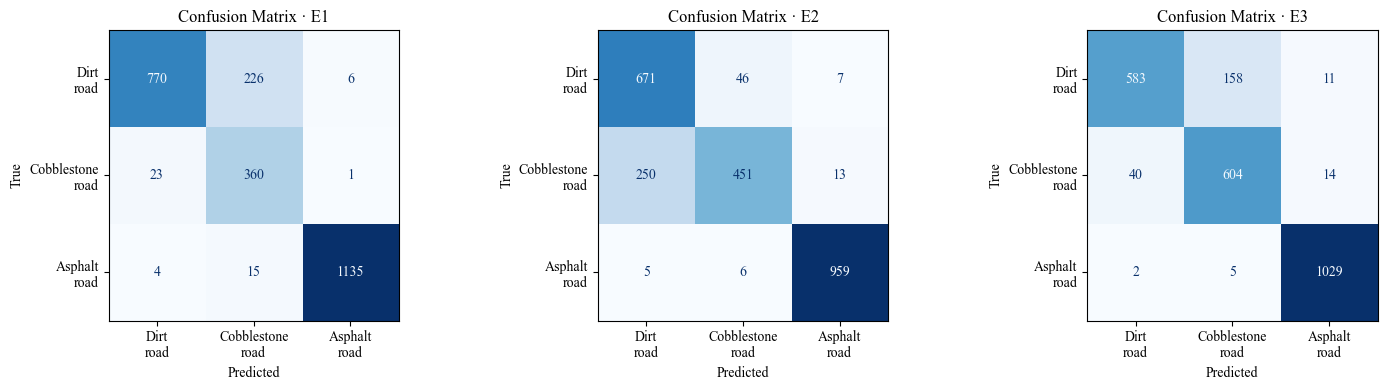

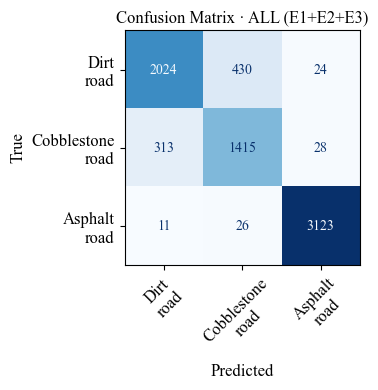

In [78]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [79]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8620    0.8168    0.8388      2478
Cobblestone road     0.7563    0.8058    0.7803      1756
    Asphalt road     0.9836    0.9883    0.9860      3160

        accuracy                         0.8875      7394
       macro avg     0.8673    0.8703    0.8683      7394
    weighted avg     0.8889    0.8875    0.8878      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [80]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_RF = RandomForestClassifier(**BEST_PARAMS, random_state=42)
final_clf_RF.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_PVS_RF.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_RF, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_PVS_RF.h'
📦 Header size: 1017.50 KB (0.994 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmpdanlbnc0.json


# 2 vị trí kết hợp - above + below

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [1]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from micromlgen import port

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "above+below"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: above+below
   → #IMU channels (không tính speed): 12
   → Tổng số kênh (đã gồm speed):      13


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [2]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [3]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: above+below) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [4]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [5]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [6]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [87]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(158, dtype=np.float32)
    
#     # ---- ABOVE ----
#     ax_above = np.array(at['acc_x_above_suspension'],  dtype=np.float32)
#     ay_above = np.array(at['acc_y_above_suspension'],  dtype=np.float32)
#     az_above = np.array(at['acc_z_above_suspension'],  dtype=np.float32)
#     gx_above = np.array(at['gyro_x_above_suspension'], dtype=np.float32)
#     gy_above = np.array(at['gyro_y_above_suspension'], dtype=np.float32)
#     gz_above = np.array(at['gyro_z_above_suspension'], dtype=np.float32)
    
#     # ---- BELOW ----
#     ax_below = np.array(at['acc_x_below_suspension'],  dtype=np.float32)
#     ay_below = np.array(at['acc_y_below_suspension'],  dtype=np.float32)
#     az_below = np.array(at['acc_z_below_suspension'],  dtype=np.float32)
#     gx_below = np.array(at['gyro_x_below_suspension'], dtype=np.float32)
#     gy_below = np.array(at['gyro_y_below_suspension'], dtype=np.float32)
#     gz_below = np.array(at['gyro_z_below_suspension'], dtype=np.float32)    
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê
#     feat[0:13] = [np.mean(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below,
#                                        sp]] # mean
#     feat[13:26] = [np.std(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below,
#                                        sp]] # sd
#     feat[26:38] = [np.sqrt(np.mean(i**2)) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                     gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # rms
#     feat[38:50] = [np.max(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # max
#     feat[50:62] = [np.min(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # min
#     feat[62:74] = [np.amax(i) - np.amin(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                      gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # range
#     feat[74:86] = [np.median(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                           gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # median
#     feat[86:98] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                          gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # interquartile range
#     feat[98:110] = [skew(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                       gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # skewness
#     feat[110:122] = [kurtosis(i) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                            gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # kurtosis
#     feat[122:134] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                        gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # hjorth mobility
#     feat[134:146] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                                                                                      gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # hjorth complexity
#     feat[146:158] = [acf(i, nlags=1)[1] for i in [ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                   gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # autocorrelation
        
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [88]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [7]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 158
ALL PVS: (7180, 158) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_above+below.npz'


## Cell 8 — Find candidates

In [90]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(22, 23)),
        "max_depth": list(range(9, 10))
    },
    "E2": {
        "n_estimators": list(range(21, 22)),
        "max_depth": list(range(9, 10))
    },
    "E3": {
        "n_estimators": list(range(20, 21)),
        "max_depth": list(range(9, 10))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train RandomForestClassifier trên toàn bộ dữ liệu (PVS 1–9) với 'params',
    export C/C++ header bằng micromlgen.port() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code) — c_code chỉ để xem nhanh; không lưu file chính thức ở đây.
    """
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_json = None
    header_tmp = "tmp_model_header.h"
    c_code = None
    err = ""
    size_mb = None
    try:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False, encoding="utf-8") as tmp:
            tmp_json = tmp.name
            pass
        c_code = port(clf, tmp_file=tmp_json)
        with open(header_tmp, "w", encoding="utf-8") as f:
            f.write(c_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_json and os.path.exists(tmp_json):
            os.remove(tmp_json)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)
            
    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_RF.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_RF.json'.")


✅ Using preset: above+below

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E1] Check 1/1: {'max_depth': 9, 'n_estimators': 22} | CV Accuracy=86.14
   -> size=0.989 MB | status=ok
[E1] BEST CANDIDATE: {'exp': 'E1', 'params': {'max_depth': 9, 'n_estimators': 22}, 'cv_accuracy': 0.8613596403401439, 'size_mb': 0.9892425537109375}

===== EXP E2: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E2] Check 1/1: {'max_depth': 9, 'n_estimators': 21} | CV Accuracy=88.46
   -> size=0.951 MB | status=ok
[E2] BEST CANDIDATE: {'exp': 'E2', 'params': {'max_depth': 9, 'n_estimators': 21}, 'cv_accuracy': 0.884649312899283, 'size_mb': 0.9505939483642578}

===== EXP E3: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E3] Check 1/1: {'max_depth': 9, 'n_estimators': 20} | CV Accuracy=87.10
   -> size=0.908 MB | status=ok
[E3] BEST CANDIDATE: {'exp': 'E3', 'params': {'max_depth': 9, 'n_estimators': 20}, 'cv_accuracy': 0.8710256252522189, 'size_mb': 0.9079113006591797

In [91]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 9, 'n_estimators': 22}, 'cv_accuracy': 0.8613, 'size_mb': 0.989} -> 91.02 Maximin, Mean - λ·Std
# {'exp': 'E2', 'params': {'max_depth': 9, 'n_estimators': 21}, 'cv_accuracy': 0.8846, 'size_mb': 0.950} -> 90.77
# {'exp': 'E3', 'params': {'max_depth': 9, 'n_estimators': 20}, 'cv_accuracy': 0.8710, 'size_mb': 0.907} -> 90.73 Borda rank, Minimax regret

## Cell 9 — Select candidates

In [92]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_RF.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = RandomForestClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 9, 'n_estimators': 22}
   E1: Accuracy(LOGO) = 86.14
   E2: Accuracy(LOGO) = 88.44
   E3: Accuracy(LOGO) = 86.71

>>> Scoring cand_E2 with params={'max_depth': 9, 'n_estimators': 21}
   E1: Accuracy(LOGO) = 85.67
   E2: Accuracy(LOGO) = 88.46
   E3: Accuracy(LOGO) = 86.72

>>> Scoring cand_E3 with params={'max_depth': 9, 'n_estimators': 20}
   E1: Accuracy(LOGO) = 85.84
   E2: Accuracy(LOGO) = 88.25
   E3: Accuracy(LOGO) = 87.10

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand_E1', 'params': {'max_depth': 9, 'n_estimators': 22}, 'size_mb': 0.989, 'S_E1': np.float64(86.14), 'S_E2': np.float64(88.44), 'S_E3': np.float64(86.71), 'mean': np.float64(87.1), 'std': np.float64(0.01)}
{'name': 'cand_E2', 'params': {'max_depth': 9, 'n_estimators': 21}, 'size_mb': 0.951, 'S_E1': np.float64(85.67), 'S_E2': np.float64(88.46), 'S_E3': np.float64(86.72), 'mean': np.float64(86.95), 'std': np.float64(0.01)}
{'name': 'cand_E3', 'params':

## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [93]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 9, "n_estimators": 20}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
Training   -> Acc =  98.19
Validation -> Acc =  90.16

===== Evaluation on E2 =====
Training   -> Acc =  99.02
Validation -> Acc =  91.15

===== Evaluation on E3 =====
Training   -> Acc =  98.65
Validation -> Acc =  90.88

===== FINAL SUMMARY =====
[Training]    Accuracy    : 98.62 ± 0.34
[Validation]  Accuracy    : 90.73 ± 0.42


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[CM] Refit & predict on E2
[CM] Refit & predict on E3


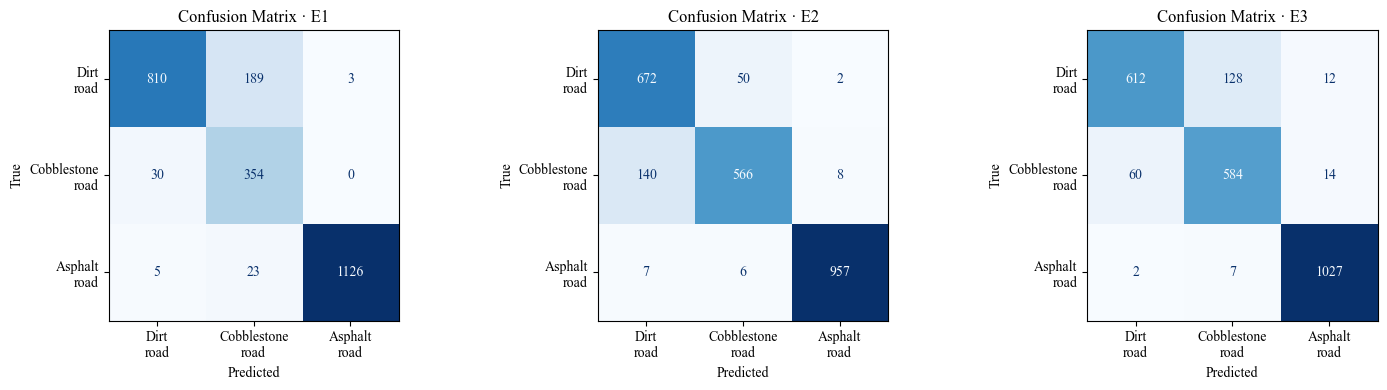

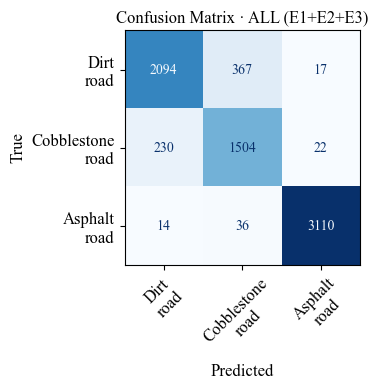

In [94]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted label", fontsize=12)
ax2.set_ylabel("True label", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [95]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8956    0.8450    0.8696      2478
Cobblestone road     0.7887    0.8565    0.8212      1756
    Asphalt road     0.9876    0.9842    0.9859      3160

        accuracy                         0.9072      7394
       macro avg     0.8906    0.8952    0.8922      7394
    weighted avg     0.9095    0.9072    0.9078      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [96]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_RF = RandomForestClassifier(**BEST_PARAMS, random_state=42)
final_clf_RF.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_PVS_RF.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_RF, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_PVS_RF.h'
📦 Header size: 929.70 KB (0.908 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmpk16xby8q.json


## Đo thời gian huấn luyện và dự đoán

In [8]:
clf = RandomForestClassifier(n_estimators=20, max_depth=9, random_state=42)

# Đo thời gian huấn luyện
start_train = time.perf_counter()
clf.fit(X_all, y_all)
end_train = time.perf_counter()
train_time = end_train - start_train

# Đo thời gian dự đoán
start_pred = time.perf_counter()
y_pred = clf.predict(X_all)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# In kết quả
print(f"Training time: {train_time:.4f} seconds")
print(f"Prediction time: {pred_time:.4f} seconds")

# Training time: 1.4042 seconds
# Prediction time: 0.0114 seconds


Training time: 1.4042 seconds
Prediction time: 0.0114 seconds


# 3 vị trí đồng thời - dashboard + above + below

## Cell 1 — Imports, cấu hình & định nghĩa Experiments 1–3

In [98]:
# Cell 1: Imports, constants, experiments
import os, json, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from micromlgen import port

# Thiết lập font mặc định Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Gốc thư mục PVS
BASE_DIR = r"D:\BVHoan\Spiiras Proceedings\Passive Vehicular Sensors Datasets"
PVS_FOLDERS = [os.path.join(BASE_DIR, f"PVS {i}") for i in range(1, 10)]

# Cấu hình phân đoạn
WINDOW_SIZE = 600
STRIDE = 300

# =========================
# Chọn thủ công cấu hình sensor
# =========================
# Hỗ trợ: "dashboard","above","below",
#         "dashboard+above", "dashboard+below", "above+below",
#         "dashboard+above+below"
ACTIVE_PRESET = "dashboard+above+below"  # <-- chỉnh tại đây khi muốn thử cấu hình khác

# Định nghĩa các kênh IMU cho từng vị trí (mỗi vị trí có cả L/R; tên cột giống nhau giữa left/right CSV)
DASH_IMU = [
    "acc_x_dashboard", "acc_y_dashboard", "acc_z_dashboard",
    "gyro_x_dashboard", "gyro_y_dashboard", "gyro_z_dashboard",
]
ABOVE_IMU = [
    "acc_x_above_suspension", "acc_y_above_suspension", "acc_z_above_suspension",
    "gyro_x_above_suspension", "gyro_y_above_suspension", "gyro_z_above_suspension",
]
BELOW_IMU = [
    "acc_x_below_suspension", "acc_y_below_suspension", "acc_z_below_suspension",
    "gyro_x_below_suspension", "gyro_y_below_suspension", "gyro_z_below_suspension",
]

# Bảng preset (chỉ liệt kê kênh IMU; cột speed sẽ được thêm một lần ở cuối)
SENSOR_PRESETS = {
    "dashboard": DASH_IMU,
    "above": ABOVE_IMU,
    "below": BELOW_IMU,
    "dashboard+above": DASH_IMU + ABOVE_IMU,
    "dashboard+below": DASH_IMU + BELOW_IMU,
    "above+below": ABOVE_IMU + BELOW_IMU,
    "dashboard+above+below": DASH_IMU + ABOVE_IMU + BELOW_IMU,
}

def choose_active_preset(name: str, include_speed: bool = True):
    if name not in SENSOR_PRESETS:
        raise ValueError(f"Unknown preset '{name}'. Allowed: {list(SENSOR_PRESETS.keys())}")
    cols = list(SENSOR_PRESETS[name])  # copy
    if include_speed:
        cols = cols + ["speed"]  # chỉ một cột speed dùng chung cho toàn cấu hình
    return cols

# Danh sách cột đầu vào cho run hiện tại
SENSOR_COLUMNS = choose_active_preset(ACTIVE_PRESET, include_speed=True)

print(f"✅ Using preset: {ACTIVE_PRESET}")
print(f"   → #IMU channels (không tính speed): {len(SENSOR_COLUMNS) - 1}")
print(f"   → Tổng số kênh (đã gồm speed):      {len(SENSOR_COLUMNS)}")

# Nhãn tác vụ chính (mutually exclusive)
LABEL_COLUMNS = ["dirt_road", "cobblestone_road", "asphalt_road"]

# Cấu hình chia theo Menegazzo
EXPERIMENTS = {
    1: {"train": ["PVS 1", "PVS 3", "PVS 4", "PVS 6", "PVS 7", "PVS 9"],
        "test":  ["PVS 2", "PVS 5", "PVS 8"]},
    2: {"train": ["PVS 1", "PVS 2", "PVS 3", "PVS 7", "PVS 8", "PVS 9"],
        "test":  ["PVS 4", "PVS 5", "PVS 6"]},
    3: {"train": ["PVS 1", "PVS 2", "PVS 4", "PVS 6", "PVS 8", "PVS 9"],
        "test":  ["PVS 3", "PVS 5", "PVS 7"]},
}


✅ Using preset: dashboard+above+below
   → #IMU channels (không tính speed): 18
   → Tổng số kênh (đã gồm speed):      19


## Cell 2 — I/O & kiểm tra: đọc 3 file trong 1 PVS, cửa sổ, majority label

In [99]:
# Cell 2: IO, validation, windowing, majority label

def load_pvs_triplet(pvs_dir: str):
    """
    Đọc 3 file trong một thư mục PVS:
      - dataset_gps_mpu_left.csv
      - dataset_gps_mpu_right.csv
      - dataset_labels.csv
    Trả về (left_df, right_df, labels_df) và kiểm tra cấu trúc tối thiểu
    theo cấu hình cột hiện hành (SENSOR_COLUMNS từ Cell 1).
    """
    left_path  = os.path.join(pvs_dir, "dataset_gps_mpu_left.csv")
    right_path = os.path.join(pvs_dir, "dataset_gps_mpu_right.csv")
    label_path = os.path.join(pvs_dir, "dataset_labels.csv")

    if not (os.path.exists(left_path) and os.path.exists(right_path) and os.path.exists(label_path)):
        raise FileNotFoundError(f"Missing one of required files in: {pvs_dir}")

    left_df  = pd.read_csv(left_path)
    right_df = pd.read_csv(right_path)
    labels_df= pd.read_csv(label_path)

    # Hàng phải khớp 1–1 giữa 3 file (đồng bộ theo chỉ số dòng)
    if not (len(left_df) == len(right_df) == len(labels_df)):
        raise ValueError(
            f"Row mismatch in {pvs_dir}: left={len(left_df)}, right={len(right_df)}, labels={len(labels_df)}"
        )

    # --- Kiểm tra cột theo preset hiện hành ---
    # Tất cả kênh trừ 'speed' phải có ở cả left và right.
    imu_cols = [c for c in SENSOR_COLUMNS if c != "speed"]
    missing_imu = [c for c in imu_cols if (c not in left_df.columns or c not in right_df.columns)]
    if missing_imu:
        raise KeyError(f"Missing IMU columns {missing_imu} in {pvs_dir} (left/right)")

    # 'speed' phải có ít nhất ở một trong hai file (giá trị hai phía giống nhau là mong đợi)
    if "speed" in SENSOR_COLUMNS:
        has_speed_left  = "speed" in left_df.columns
        has_speed_right = "speed" in right_df.columns
        if not (has_speed_left or has_speed_right):
            raise KeyError(f"Missing column 'speed' in {pvs_dir} (neither left nor right)")

        # Nếu có ở cả hai, kiểm tra gần như nhau (sanity check, không dừng nếu lệch rất nhỏ do làm tròn)
        if has_speed_left and has_speed_right:
            try:
                if not np.allclose(left_df["speed"].values, right_df["speed"].values, atol=1e-6, rtol=1e-6):
                    print(f"[Warn] 'speed' differs between left/right in {pvs_dir}. "
                          f"Values should be identical (GPS shared). Proceeding with files as-is.")
            except Exception:
                # Trường hợp dtype lạ hoặc NaN; chỉ cảnh báo nhẹ
                print(f"[Warn] Could not compare 'speed' columns in {pvs_dir} due to dtype/NaN issues.")

    # Cột nhãn one-hot bắt buộc
    for col in LABEL_COLUMNS:
        if col not in labels_df.columns:
            raise KeyError(f"Label column '{col}' missing in {pvs_dir}/dataset_labels.csv")

    return left_df, right_df, labels_df

def window_indices(n_samples: int, window: int, stride: int):
    """Sinh danh sách (start, end) cho các cửa sổ trượt."""
    idx = []
    start = 0
    while start + window <= n_samples:
        idx.append((start, start + window))
        start += stride
    return idx

def majority_label_onehot(block_labels, label_cols=LABEL_COLUMNS):
    """
    Lấy nhãn majority trong cửa sổ theo tổng one-hot; khi hòa,
    dùng mode() giống Menegazzo.
    """
    sums = block_labels[label_cols].sum(axis=0)
    max_sum = sums.max()
    tied = [cls for cls, val in sums.items() if val == max_sum]
    if len(tied) == 1:
        return tied[0]
    # dùng mode() giống Menegazzo
    mode_label = block_labels[label_cols].mode().iloc[0]
    for cls in label_cols:
        if mode_label[cls] == 1:
            return cls
    return tied[0]


## Cell 3 — Phân đoạn một lần duy nhất và gắn provenance PVS

In [100]:
# Cell 3: Single-pass segmentation with provenance (both sides as independent samples)

def build_windows_by_pvs(pvs_folders):
    """
    Trả về:
      windows_by_pvs = {
        'PVS 1': {'dirt_road': [np.array(WINDOW_SIZE, n_channels), ...],
                  'cobblestone_road': [...],
                  'asphalt_road': [...]},
        ...
      }
    Mỗi cửa sổ là một mẫu; left/right được coi là 2 mẫu độc lập (đúng Menegazzo).
    """
    windows_by_pvs = {}
    global_summary = Counter()

    for pvs_dir in pvs_folders:
        pvs_name = os.path.basename(pvs_dir)  # "PVS i"
        try:
            left_df, right_df, labels_df = load_pvs_triplet(pvs_dir)
        except Exception as e:
            print(f"[WARN] Skip {pvs_name}: {e}")
            continue

        # -----------------------------
        # 1) Chuẩn bị tín hiệu đầu vào
        # -----------------------------
        # Sao chép SENSOR_COLUMNS để tách speed riêng
        cols_no_speed = [c for c in SENSOR_COLUMNS if c != "speed"]
        include_speed = "speed" in SENSOR_COLUMNS

        # Các cột IMU phải có ở cả left & right
        left_sig_imu  = left_df[cols_no_speed].to_numpy(dtype=np.float32)
        right_sig_imu = right_df[cols_no_speed].to_numpy(dtype=np.float32)

        # Speed: chỉ lấy một nguồn (left ưu tiên)
        if include_speed:
            if "speed" in left_df.columns:
                speed_vec = left_df["speed"].to_numpy(dtype=np.float32)
            else:
                speed_vec = right_df["speed"].to_numpy(dtype=np.float32)
            speed_vec = speed_vec.reshape(-1, 1)
            # Ghép speed thành cột cuối
            left_sig  = np.hstack([left_sig_imu,  speed_vec])
            right_sig = np.hstack([right_sig_imu, speed_vec])
        else:
            left_sig, right_sig = left_sig_imu, right_sig_imu

        # -----------------------------
        # 2) Xử lý nhãn
        # -----------------------------
        labels_main = labels_df[LABEL_COLUMNS].astype(int)
        n = len(labels_main)
        win_idxs = window_indices(n, WINDOW_SIZE, STRIDE)
        if not win_idxs:
            print(f"[INFO] {pvs_name}: not enough samples for one window ({n} < {WINDOW_SIZE})")
            continue

        # -----------------------------
        # 3) Tạo kho lưu kết quả
        # -----------------------------
        windows_by_pvs.setdefault(pvs_name, {k: [] for k in LABEL_COLUMNS})

        # -----------------------------
        # 4) Cắt cửa sổ và gán nhãn
        # -----------------------------
        for (s, e) in win_idxs:
            cls = majority_label_onehot(labels_main.iloc[s:e], LABEL_COLUMNS)

            # Mỗi bên là một mẫu độc lập
            wL = left_sig[s:e, :]
            wR = right_sig[s:e, :]

            windows_by_pvs[pvs_name][cls].append(wL)
            windows_by_pvs[pvs_name][cls].append(wR)
            global_summary[cls] += 2

    # -----------------------------
    # 5) Log thống kê
    # -----------------------------
    print(f"=== Windows per PVS (preset: {ACTIVE_PRESET}) ===")
    for pvs_name in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
        line = [f"{cls}:{len(windows_by_pvs[pvs_name][cls])}" for cls in LABEL_COLUMNS]
        print(f"{pvs_name} -> " + " | ".join(line))

    print("\n=== Global class totals ===")
    for cls in LABEL_COLUMNS:
        print(f"{cls:17s}: {global_summary[cls]}")

    return windows_by_pvs

# Thực thi để sinh dữ liệu phân đoạn
windows_by_pvs = build_windows_by_pvs(PVS_FOLDERS)


=== Windows per PVS (preset: dashboard+above+below) ===
PVS 1 -> dirt_road:172 | cobblestone_road:412 | asphalt_road:374
PVS 2 -> dirt_road:298 | cobblestone_road:138 | asphalt_road:392
PVS 3 -> dirt_road:190 | cobblestone_road:176 | asphalt_road:336
PVS 4 -> dirt_road:160 | cobblestone_road:384 | asphalt_road:336
PVS 5 -> dirt_road:404 | cobblestone_road:120 | asphalt_road:366
PVS 6 -> dirt_road:160 | cobblestone_road:210 | asphalt_road:268
PVS 7 -> dirt_road:158 | cobblestone_road:362 | asphalt_road:334
PVS 8 -> dirt_road:300 | cobblestone_road:126 | asphalt_road:396
PVS 9 -> dirt_road:154 | cobblestone_road:168 | asphalt_road:286

=== Global class totals ===
dirt_road        : 1996
cobblestone_road : 2096
asphalt_road     : 3088


## Cell 4 — Tạo đủ 3 splits theo Menegazzo và in thống kê

In [101]:
# Cell 4: Build ALL 3 Menegazzo splits + stats

def _collect_from_pvs(pvs_list, windows_by_pvs, label_cols=LABEL_COLUMNS):
    bucket = {c: [] for c in label_cols}
    for pvs in pvs_list:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing; skipping.")
            continue
        for cls in label_cols:
            bucket[cls].extend(windows_by_pvs[pvs][cls])
    return bucket

def _print_split_stats(exp_id, split_name, lists_by_class, label_cols=LABEL_COLUMNS):
    total = sum(len(v) for v in lists_by_class.values())
    print(f"[Experiment {exp_id} · {split_name.upper()}] Total windows: {total}")
    for cls in label_cols:
        print(f"  {cls:17s}: {len(lists_by_class[cls])}")

def make_all_splits(windows_by_pvs, experiments=EXPERIMENTS):
    """
    Trả về:
      splits = {
        1: {"train": {"dirt_road":[...], ...}, "test": {...}},
        2: {...},
        3: {...}
      }
    """
    splits = {}
    for exp_id, conf in experiments.items():
        tr_pvs, te_pvs = conf["train"], conf["test"]
        train_lists = _collect_from_pvs(tr_pvs, windows_by_pvs)
        test_lists  = _collect_from_pvs(te_pvs, windows_by_pvs)

        splits[exp_id] = {"train": train_lists, "test": test_lists}

        print(f"=== Experiment {exp_id} ===")
        _print_split_stats(exp_id, "train", train_lists)
        _print_split_stats(exp_id, "test",  test_lists)

    return splits

splits = make_all_splits(windows_by_pvs)


=== Experiment 1 ===
[Experiment 1 · TRAIN] Total windows: 4640
  dirt_road        : 994
  cobblestone_road : 1712
  asphalt_road     : 1934
[Experiment 1 · TEST] Total windows: 2540
  dirt_road        : 1002
  cobblestone_road : 384
  asphalt_road     : 1154
=== Experiment 2 ===
[Experiment 2 · TRAIN] Total windows: 4772
  dirt_road        : 1272
  cobblestone_road : 1382
  asphalt_road     : 2118
[Experiment 2 · TEST] Total windows: 2408
  dirt_road        : 724
  cobblestone_road : 714
  asphalt_road     : 970
=== Experiment 3 ===
[Experiment 3 · TRAIN] Total windows: 4734
  dirt_road        : 1244
  cobblestone_road : 1438
  asphalt_road     : 2052
[Experiment 3 · TEST] Total windows: 2446
  dirt_road        : 752
  cobblestone_road : 658
  asphalt_road     : 1036


## Cell 5 — Sinh biến cho cả 3 experiment (không ghi đè nhau)

In [102]:
# Cell 5: Variables for all 3 experiments with suffixes _E1/_E2/_E3

def _vars_for_all_experiments(splits_dict):
    for exp_id in (1, 2, 3):
        sd = splits_dict[exp_id]

        globals()[f"train_dirt_road_E{exp_id}"]         = sd["train"]["dirt_road"]
        globals()[f"train_cobblestone_road_E{exp_id}"]  = sd["train"]["cobblestone_road"]
        globals()[f"train_asphalt_road_E{exp_id}"]      = sd["train"]["asphalt_road"]

        globals()[f"test_dirt_road_E{exp_id}"]          = sd["test"]["dirt_road"]
        globals()[f"test_cobblestone_road_E{exp_id}"]   = sd["test"]["cobblestone_road"]
        globals()[f"test_asphalt_road_E{exp_id}"]       = sd["test"]["asphalt_road"]

_vars_for_all_experiments(splits)

# peek a few counts so you can sanity-check at a glance
for k in ("train_dirt_road", "train_cobblestone_road", "train_asphalt_road",
          "test_dirt_road", "test_cobblestone_road", "test_asphalt_road"):
    for e in (1, 2, 3):
        v = globals()[f"{k}_E{e}"]
        print(f"{k}_E{e:1d}: {len(v)} windows")


train_dirt_road_E1: 994 windows
train_dirt_road_E2: 1272 windows
train_dirt_road_E3: 1244 windows
train_cobblestone_road_E1: 1712 windows
train_cobblestone_road_E2: 1382 windows
train_cobblestone_road_E3: 1438 windows
train_asphalt_road_E1: 1934 windows
train_asphalt_road_E2: 2118 windows
train_asphalt_road_E3: 2052 windows
test_dirt_road_E1: 1002 windows
test_dirt_road_E2: 724 windows
test_dirt_road_E3: 752 windows
test_cobblestone_road_E1: 384 windows
test_cobblestone_road_E2: 714 windows
test_cobblestone_road_E3: 658 windows
test_asphalt_road_E1: 1154 windows
test_asphalt_road_E2: 970 windows
test_asphalt_road_E3: 1036 windows


## Cell 6 — Tạo data_train/data_test + label_train/label_test cho từng experiment

In [103]:
# Cell 6: Build data_/label_ arrays for EACH experiment,
# groups cho mỗi cửa sổ (train/test) theo PVS (để dùng Group-aware CV)

def _vars_with_groups_for_experiment(exp_id):
    """
    Sinh data_/label_ + groups_ cho exp_id.
    Group = tên PVS của cửa sổ đó.
    Dùng danh sách cột linh hoạt SENSOR_COLUMNS (theo preset đã chọn).
    """
    data_train, label_train, groups_train = [], [], []

    # --- Build TRAIN ---
    for pvs in EXPERIMENTS[exp_id]["train"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TRAIN")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                # mỗi acts là np.array(window_size, n_channels)
                data_train.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_train.append(lab)
                groups_train.append(pvs)

    # --- Build TEST ---
    data_test, label_test, groups_test = [], [], []
    for pvs in EXPERIMENTS[exp_id]["test"]:
        if pvs not in windows_by_pvs:
            print(f"[WARN] {pvs} missing in windows_by_pvs; skip TEST")
            continue
        for cls, lab in zip(LABEL_COLUMNS, [0, 1, 2]):
            for acts in windows_by_pvs[pvs][cls]:
                data_test.append(pd.DataFrame(acts, columns=SENSOR_COLUMNS))
                label_test.append(lab)
                groups_test.append(pvs)

    # --- Lưu vào biến toàn cục ---
    globals()[f"data_train_E{exp_id}"]   = data_train
    globals()[f"label_train_E{exp_id}"]  = label_train
    globals()[f"groups_train_E{exp_id}"] = groups_train

    globals()[f"data_test_E{exp_id}"]    = data_test
    globals()[f"label_test_E{exp_id}"]   = label_test
    globals()[f"groups_test_E{exp_id}"]  = groups_test

# Rebuild để có groups (E1–E3)
_vars_with_groups_for_experiment(1)
_vars_with_groups_for_experiment(2)
_vars_with_groups_for_experiment(3)

print("E1:", len(data_train_E1), "train /", len(data_test_E1), "test | #groups(train) =", len(set(groups_train_E1)))
print("E2:", len(data_train_E2), "train /", len(data_test_E2), "test | #groups(train) =", len(set(groups_train_E2)))
print("E3:", len(data_train_E3), "train /", len(data_test_E3), "test | #groups(train) =", len(set(groups_train_E3)))


E1: 4640 train / 2540 test | #groups(train) = 6
E2: 4772 train / 2408 test | #groups(train) = 6
E3: 4734 train / 2446 test | #groups(train) = 6


## Cell 7 — Feature extraction

In [104]:
# # Cell 7: Trích xuất đặc trưng

# def featuresFromBuffer(at):
#     feat = np.zeros(236, dtype=np.float32)
    
#     # ---- DASHBOARD ----
#     ax_dashboard = np.array(at['acc_x_dashboard'],  dtype=np.float32)
#     ay_dashboard = np.array(at['acc_y_dashboard'],  dtype=np.float32)
#     az_dashboard = np.array(at['acc_z_dashboard'],  dtype=np.float32)
#     gx_dashboard = np.array(at['gyro_x_dashboard'], dtype=np.float32)
#     gy_dashboard = np.array(at['gyro_y_dashboard'], dtype=np.float32)
#     gz_dashboard = np.array(at['gyro_z_dashboard'], dtype=np.float32)
    
#     # ---- ABOVE ----
#     ax_above = np.array(at['acc_x_above_suspension'],  dtype=np.float32)
#     ay_above = np.array(at['acc_y_above_suspension'],  dtype=np.float32)
#     az_above = np.array(at['acc_z_above_suspension'],  dtype=np.float32)
#     gx_above = np.array(at['gyro_x_above_suspension'], dtype=np.float32)
#     gy_above = np.array(at['gyro_y_above_suspension'], dtype=np.float32)
#     gz_above = np.array(at['gyro_z_above_suspension'], dtype=np.float32)
    
#     # ---- BELOW ----
#     ax_below = np.array(at['acc_x_below_suspension'],  dtype=np.float32)
#     ay_below = np.array(at['acc_y_below_suspension'],  dtype=np.float32)
#     az_below = np.array(at['acc_z_below_suspension'],  dtype=np.float32)
#     gx_below = np.array(at['gyro_x_below_suspension'], dtype=np.float32)
#     gy_below = np.array(at['gyro_y_below_suspension'], dtype=np.float32)
#     gz_below = np.array(at['gyro_z_below_suspension'], dtype=np.float32)    
    
#     # ---- SPEED (chung) ----
#     sp = np.array(at['speed'], dtype=np.float32)
    
#     # Đặc trưng thống kê
#     feat[0:19] = [np.mean(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below,
#                                        sp]] # mean
#     feat[19:38] = [np.std(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below,
#                                        sp]] # sd
#     feat[38:56] = [np.sqrt(np.mean(i**2)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                     gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # rms
#     feat[56:74] = [np.max(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # max
#     feat[74:92] = [np.min(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # min
#     feat[92:110] = [np.amax(i) - np.amin(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                       gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # range
#     feat[110:128] = [np.median(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                             gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # median
#     feat[128:146] = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                            gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # interquartile range
#     feat[146:164] = [skew(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # skewness
#     feat[164:182] = [kurtosis(i) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                            gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # kurtosis
#     feat[182:200] = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                        gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # hjorth mobility
#     feat[200:218] = [(np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) / np.sqrt(np.var(np.diff(i)) / np.var(i))) for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                                                                                                      gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # hjorth complexity
#     feat[218:236] = [acf(i, nlags=1)[1] for i in [ax_dashboard, ay_dashboard, az_dashboard, ax_above, ay_above, az_above, ax_below, ay_below, az_below,
#                                                   gx_dashboard, gy_dashboard, gz_dashboard, gx_above, gy_above, gz_above, gx_below, gy_below, gz_below]] # autocorrelation
        
#     return feat

# # Trích xuất đặc trưng cho từng cửa sổ
# train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
# test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
# train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
# test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
# train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
# test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

# # Ép sang numpy array
# train_features_E1 = np.array(train_features_E1, dtype=np.float32)
# test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
# train_features_E2 = np.array(train_features_E2, dtype=np.float32)
# test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
# train_features_E3 = np.array(train_features_E3, dtype=np.float32)
# test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

# print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
# print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
# print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
# print('Feature dimension:', train_features_E1.shape[1])

# # Gom toàn bộ dữ liệu từ PVS 1..9 (tránh dùng E1/E2/E3 để không đếm trùng)
# cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
# X_all, y_all = [], []

# # Đảm bảo thứ tự PVS 1..9 ổn định
# for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#     for cls_name, cls_id in cls_map:
#         for buf in windows_by_pvs[pvs][cls_name]:
#             # buf là ndarray (WINDOW_SIZE x len(SENSOR_COLUMNS))
#             at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#             feat = featuresFromBuffer(at)
#             X_all.append(feat)
#             y_all.append(cls_id)

# X_all = np.asarray(X_all, dtype=np.float32)
# y_all = np.asarray(y_all, dtype=np.int32)
# print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))


## Cell 7A — Tính & Lưu cache

In [105]:
# # Cell 7A: Compute & cache features for the current ACTIVE_PRESET

# def _extract_features_for_splits():
#     # y nguyên format Cell 7: tạo các mảng đặc trưng cho E1/E2/E3
#     train_features_E1 = [featuresFromBuffer(action) for action in data_train_E1]
#     test_features_E1  = [featuresFromBuffer(action) for action in data_test_E1]
#     train_features_E2 = [featuresFromBuffer(action) for action in data_train_E2]
#     test_features_E2  = [featuresFromBuffer(action) for action in data_test_E2]
#     train_features_E3 = [featuresFromBuffer(action) for action in data_train_E3]
#     test_features_E3  = [featuresFromBuffer(action) for action in data_test_E3]

#     # Ép sang numpy array
#     train_features_E1 = np.array(train_features_E1, dtype=np.float32)
#     test_features_E1  = np.array(test_features_E1,  dtype=np.float32)
#     train_features_E2 = np.array(train_features_E2, dtype=np.float32)
#     test_features_E2  = np.array(test_features_E2,  dtype=np.float32)
#     train_features_E3 = np.array(train_features_E3, dtype=np.float32)
#     test_features_E3  = np.array(test_features_E3,  dtype=np.float32)

#     return (train_features_E1, test_features_E1,
#             train_features_E2, test_features_E2,
#             train_features_E3, test_features_E3)

# def _extract_features_all_pvs():
#     # Y nguyên logic gom ALL PVS (tránh đếm trùng E1/E2/E3)
#     cls_map = [("dirt_road", 0), ("cobblestone_road", 1), ("asphalt_road", 2)]
#     X_all, y_all = [], []

#     for pvs in sorted(windows_by_pvs.keys(), key=lambda s: int(s.split()[-1])):
#         for cls_name, cls_id in cls_map:
#             for buf in windows_by_pvs[pvs][cls_name]:
#                 at = pd.DataFrame(buf, columns=SENSOR_COLUMNS)
#                 feat = featuresFromBuffer(at)
#                 X_all.append(feat)
#                 y_all.append(cls_id)

#     X_all = np.asarray(X_all, dtype=np.float32)
#     y_all = np.asarray(y_all, dtype=np.int32)
#     return X_all, y_all

# def _save_feature_cache(fname,
#                         train_features_E1, test_features_E1,
#                         train_features_E2, test_features_E2,
#                         train_features_E3, test_features_E3,
#                         X_all, y_all):
#     # Lưu gọn bằng NPZ nén
#     np.savez_compressed(
#         fname,
#         ACTIVE_PRESET=np.array([ACTIVE_PRESET]),
#         SENSOR_COLUMNS=np.array(SENSOR_COLUMNS),
#         WINDOW_SIZE=np.array([WINDOW_SIZE], dtype=np.int32),
#         STRIDE=np.array([STRIDE], dtype=np.int32),
#         LABEL_COLUMNS=np.array(LABEL_COLUMNS),

#         train_features_E1=train_features_E1,
#         test_features_E1=test_features_E1,
#         train_features_E2=train_features_E2,
#         test_features_E2=test_features_E2,
#         train_features_E3=train_features_E3,
#         test_features_E3=test_features_E3,

#         X_all=X_all,
#         y_all=y_all
#     )

# # ---- Thực thi: tính & lưu ----
# cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
# print(f"⏳ Computing features for preset: {ACTIVE_PRESET} ...")

# (train_features_E1, test_features_E1,
#  train_features_E2, test_features_E2,
#  train_features_E3, test_features_E3) = _extract_features_for_splits()

# print("   • Splits done:",
#       f"E1: {train_features_E1.shape} / {test_features_E1.shape} |",
#       f"E2: {train_features_E2.shape} / {test_features_E2.shape} |",
#       f"E3: {train_features_E3.shape} / {test_features_E3.shape}")

# X_all, y_all = _extract_features_all_pvs()
# print("   • ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))

# _save_feature_cache(cache_name,
#                     train_features_E1, test_features_E1,
#                     train_features_E2, test_features_E2,
#                     train_features_E3, test_features_E3,
#                     X_all, y_all)

# size_bytes = os.path.getsize(cache_name)
# print(f"✅ Saved cache to '{cache_name}' ({size_bytes/1024/1024:.3f} MB)")


## Cell 7B — Nạp cache (dùng cho chạy nhanh về sau)

In [106]:
# Cell 7B: Load cached feature set for the current ACTIVE_PRESET

cache_name = f"feature_set_{ACTIVE_PRESET}.npz"
if not os.path.exists(cache_name):
    raise FileNotFoundError(f"Feature cache not found: {cache_name}. Hãy chạy Cell 7A trước để tạo cache.")

data = np.load(cache_name, allow_pickle=True)

# Khôi phục biến đúng tên như Cell 7 gốc
train_features_E1 = data["train_features_E1"]
test_features_E1  = data["test_features_E1"]
train_features_E2 = data["train_features_E2"]
test_features_E2  = data["test_features_E2"]
train_features_E3 = data["train_features_E3"]
test_features_E3  = data["test_features_E3"]

X_all = data["X_all"]
y_all = data["y_all"]

# (tuỳ chọn) kiểm tra meta để cảnh báo nếu lệch preset
_cached_preset = str(data["ACTIVE_PRESET"][0])
if _cached_preset != ACTIVE_PRESET:
    print(f"[WARN] Cache preset = '{_cached_preset}' khác với ACTIVE_PRESET hiện tại = '{ACTIVE_PRESET}'")

# In thống kê giống Cell 7 gốc
print('E1:', len(train_features_E1), 'train samples /', len(test_features_E1), 'test samples')
print('E2:', len(train_features_E2), 'train samples /', len(test_features_E2), 'test samples')
print('E3:', len(train_features_E3), 'train samples /', len(test_features_E3), 'test samples')
print('Feature dimension:', train_features_E1.shape[1])
print("ALL PVS:", X_all.shape, "| class dist:", np.bincount(y_all))
print(f"✅ Loaded cache from '{cache_name}'")


E1: 4640 train samples / 2540 test samples
E2: 4772 train samples / 2408 test samples
E3: 4734 train samples / 2446 test samples
Feature dimension: 236
ALL PVS: (7180, 236) | class dist: [1996 2096 3088]
✅ Loaded cache from 'feature_set_dashboard+above+below.npz'


## Cell 8 — Find candidates

In [107]:
# Cell 8: Find candidates, LOGO trên 3 experiment → lấy 3 bộ tham số ứng viên (Accuracy), kèm kiểm tra model size ≤ 1.00 MB
print(f"✅ Using preset: {ACTIVE_PRESET}")

# Định nghĩa grid riêng cho từng exp
param_grids = {
    "E1": {
        "n_estimators": list(range(13, 14)),
        "max_depth": list(range(10, 12))
    },
    "E2": {
        "n_estimators": list(range(31, 32)),
        "max_depth": list(range(8, 9))
    },
    "E3": {
        "n_estimators": list(range(50, 51)),
        "max_depth": list(range(7, 8))
    }
}

# ---------------------- HÀM ĐO SIZE ----------------------
def measure_model_size_mb(params, X_full, y_full):
    """
    Train RandomForestClassifier trên toàn bộ dữ liệu (PVS 1–9) với 'params',
    export C/C++ header bằng micromlgen.port() rồi đo kích thước (MB).
    Trả về (size_mb, error_msg, c_code) — c_code chỉ để xem nhanh; không lưu file chính thức ở đây.
    """
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(X_full, y_full)

    tmp_json = None
    header_tmp = "tmp_model_header.h"
    c_code = None
    err = ""
    size_mb = None
    try:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False, encoding="utf-8") as tmp:
            tmp_json = tmp.name
            pass
        c_code = port(clf, tmp_file=tmp_json)
        with open(header_tmp, "w", encoding="utf-8") as f:
            f.write(c_code)
        size_bytes = os.path.getsize(header_tmp)
        size_mb = size_bytes / (1024 * 1024)
    except Exception as e:
        err = str(e)
    finally:
        if tmp_json and os.path.exists(tmp_json):
            os.remove(tmp_json)
        if os.path.exists(header_tmp):
            os.remove(header_tmp)
            
    return size_mb, err, c_code

# ---------------------- HÀM LOGO + GRIDSEARCH CHO 1 EXP ----------------------
def run_logo_for_experiment(exp_name, X_train, y_train, groups, X_full_for_size, y_full_for_size,
                            param_grid, size_limit_mb=1.00):
    """
    - Chạy GridSearchCV với LOGO (Accuracy) trên (X_train, y_train, groups).
    - Với từng bộ params trong kết quả, train lại trên toàn bộ PVS 1–9 để đo size.
    - Chọn bộ params có:
        * size ≤ size_limit_mb
        * điểm cv (mean test Accuracy) cao nhất
      Tie-break: model nhỏ hơn → depth thấp hơn → số cây ít hơn.
    - Trả về dict ứng viên cho exp này.
    """
    print(f"\n===== EXP {exp_name}: START LOGO GRID (Accuracy) + SIZE CHECK ≤ {size_limit_mb:.2f} MB =====")
    logo = LeaveOneGroupOut()
    gs = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=logo.split(X_train, y_train, groups=groups),
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_cv = -np.inf
    best = None

    for i, params in enumerate(gs.cv_results_["params"], 1):
        cv_mean = gs.cv_results_["mean_test_score"][i-1]
        print(f"[{exp_name}] Check {i}/{len(gs.cv_results_['params'])}: {params} | CV Accuracy={cv_mean*100:.2f}")

        size_mb, err, _ = measure_model_size_mb(params, X_full_for_size, y_full_for_size)
        status = "ok"
        if err:
            status = f"error: {err}"
        elif size_mb is None:
            status = "error: size_none"
        elif size_mb > size_limit_mb:
            status = "oversize"

        print(f"   -> size={None if size_mb is None else f'{size_mb:.3f} MB'} | status={status}")

        if status == "ok":
            # update theo tiêu chí: cv cao nhất → size nhỏ hơn → depth thấp hơn → n_estimators ít hơn
            if (cv_mean > best_cv or
                (np.isclose(cv_mean, best_cv) and size_mb < best["size_mb"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] < best["params"]["max_depth"]) or
                (np.isclose(cv_mean, best_cv) and np.isclose(size_mb, best["size_mb"]) and params["max_depth"] == best["params"]["max_depth"] and params["n_estimators"] < best["params"]["n_estimators"])
               ):
                best_cv = cv_mean
                best = {
                    "exp": exp_name,
                    "params": dict(params),
                    "cv_accuracy": float(cv_mean),
                    "size_mb": float(size_mb)
                }

    if best is None:
        best = {
            "exp": exp_name,
            "params": None,
            "cv_accuracy": None,
            "size_mb": None,
            "note": f"No feasible params ≤ {size_limit_mb:.2f} MB (or export error)"
        }
        print(f"[{exp_name}] WARNING: Không tìm thấy cấu hình khả thi (≤ {size_limit_mb:.2f} MB).")

    print(f"[{exp_name}] BEST CANDIDATE:", best)
    return best

candidates = []
candidates.append(run_logo_for_experiment("E1", train_features_E1, label_train_E1, groups_train_E1, X_all, y_all, param_grids["E1"]))
candidates.append(run_logo_for_experiment("E2", train_features_E2, label_train_E2, groups_train_E2, X_all, y_all, param_grids["E2"]))
candidates.append(run_logo_for_experiment("E3", train_features_E3, label_train_E3, groups_train_E3, X_all, y_all, param_grids["E3"]))

print("\n===== 3 ỨNG VIÊN LOGO (Accuracy, size≤1.00MB) =====")
for c in candidates:
    print(c)

# Lưu lại để dùng cho bước “chốt cuối”
with open("logo_candidates_RF.json", "w", encoding="utf-8") as f:
    json.dump(candidates, f, indent=2, ensure_ascii=False)

print("Đã lưu 3 ứng viên vào 'logo_candidates_RF.json'.")


✅ Using preset: dashboard+above+below

===== EXP E1: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====


[E1] Check 1/2: {'max_depth': 10, 'n_estimators': 13} | CV Accuracy=86.18
   -> size=0.739 MB | status=ok
[E1] Check 2/2: {'max_depth': 11, 'n_estimators': 13} | CV Accuracy=85.67
   -> size=0.871 MB | status=ok
[E1] BEST CANDIDATE: {'exp': 'E1', 'params': {'max_depth': 10, 'n_estimators': 13}, 'cv_accuracy': 0.8617704738500391, 'size_mb': 0.7390651702880859}

===== EXP E2: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E2] Check 1/1: {'max_depth': 8, 'n_estimators': 31} | CV Accuracy=88.72
   -> size=0.967 MB | status=ok
[E2] BEST CANDIDATE: {'exp': 'E2', 'params': {'max_depth': 8, 'n_estimators': 31}, 'cv_accuracy': 0.8872346204992669, 'size_mb': 0.9674510955810547}

===== EXP E3: START LOGO GRID (Accuracy) + SIZE CHECK ≤ 1.00 MB =====
[E3] Check 1/1: {'max_depth': 7, 'n_estimators': 50} | CV Accuracy=87.12
   -> size=0.995 MB | status=ok
[E3] BEST CANDIDATE: {'exp': 'E3', 'params': {'max_depth': 7, 'n_estimators': 50}, 'cv_accuracy': 0.8711989823492092, 'size_mb': 0.994724

In [108]:
# mean, sd, rms, max, min, range, median, iqr, skew, kurt, hm, hc, acf
# {'exp': 'E1', 'params': {'max_depth': 10, 'n_estimators': 13}, 'cv_accuracy': 0.8617, 'size_mb': 0.739} -> 89.49 Maximin, Mean - λ·Std
# {'exp': 'E2', 'params': {'max_depth': 08, 'n_estimators': 31}, 'cv_accuracy': 0.8872, 'size_mb': 0.967} -> 90.38
# {'exp': 'E3', 'params': {'max_depth': 07, 'n_estimators': 50}, 'cv_accuracy': 0.8711, 'size_mb': 0.994} -> 89.65 Borda rank, Minimax regret

## Cell 9 — Select candidates

In [109]:
# Cell 9: Select candidates, thử 4 tiêu chí trên bộ ba ứng viên (train-only, LOGO)

# ========= NẠP 3 ỨNG VIÊN =========
with open("logo_candidates_RF.json", "r", encoding="utf-8") as f:
    candidates = json.load(f)

# Đặt tên ngắn gọn cho ứng viên theo exp gốc của nó: 'cand_E1', 'cand_E2', 'cand_E3'
for c in candidates:
    c["name"] = f"cand_{c['exp']}"

# ========= CHUẨN BỊ DỮ LIỆU TRAIN+GROUPS CHO 3 EXP =========
X_train_dict = {
    "E1": train_features_E1,
    "E2": train_features_E2,
    "E3": train_features_E3,
}
y_train_dict = {
    "E1": np.asarray(label_train_E1),
    "E2": np.asarray(label_train_E2),
    "E3": np.asarray(label_train_E3),
}
groups_dict = {
    "E1": np.asarray(groups_train_E1),
    "E2": np.asarray(groups_train_E2),
    "E3": np.asarray(groups_train_E3),
}

# ========= HÀM LOGO SCORE (Accuracy, train-only) =========
def logo_cv_accuracy_for_exp(params, X, y, groups):
    """
    Cố định bộ tham số 'params' => chạy LOGO trên (X,y,groups) => trả về mean Accuracy.
    """
    logo = LeaveOneGroupOut()
    f1s = []
    # Duyệt từng split LOGO
    for tr_idx, va_idx in logo.split(X, y, groups=groups):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]
        clf = RandomForestClassifier(**params, random_state=42)
        clf.fit(X_tr, y_tr)
        y_hat = clf.predict(X_va)
        f1s.append(accuracy_score(y_va, y_hat))
    return float(np.mean(f1s))

# ========= TÍNH MA TRẬN ĐIỂM S_k(h) (k ∈ {E1,E2,E3}, h ∈ 3 ứng viên) =========
exps = ["E1", "E2", "E3"]
H = len(candidates)
K = len(exps)

scores = np.zeros((H, K), dtype=float)  # S[h,k] = Accuracy của ứng viên h trên exp k
for h, cand in enumerate(candidates):
    params = cand["params"]
    print(f"\n>>> Scoring {cand['name']} with params={params}")
    for k, ek in enumerate(exps):
        S_hk = logo_cv_accuracy_for_exp(params, X_train_dict[ek], y_train_dict[ek], groups_dict[ek])
        scores[h, k] = S_hk
        print(f"   {ek}: Accuracy(LOGO) = {S_hk*100:.2f}")

# ========= TIỆN ÍCH: TIE-BREAK =========
def tie_break_key(h):
    # size nhỏ hơn → depth nhỏ hơn → n_estimators ít hơn
    size = candidates[h].get("size_mb", np.inf)
    depth = candidates[h]["params"]["max_depth"]
    trees = candidates[h]["params"]["n_estimators"]
    return (size, depth, trees)

# ========= 1) MAXIMIN =========
worst_case = scores.min(axis=1)             # min_k S_k(h)
best_h_maximin = max(range(H), key=lambda h: (worst_case[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= 2) BORDA RANK =========
def ranks_desc(vals):
    """
    Trả về rank (1 = tốt nhất) theo thứ tự giảm dần của vals.
    Ties => average-rank.
    """
    vals = np.asarray(vals)
    # sắp xếp giảm dần
    order = np.argsort(-vals)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(vals) + 1, dtype=float)
    # xử lý ties (average rank)
    for v in np.unique(vals):
        idx = np.where(vals == v)[0]
        if len(idx) > 1:
            avg = ranks[idx].mean()
            ranks[idx] = avg
    return ranks

borda = np.zeros(H, dtype=float)
for k in range(K):
    borda += ranks_desc(scores[:, k])
best_h_borda = min(range(H), key=lambda h: (borda[h], tie_break_key(h)))

# ========= 3) MINIMAX REGRET =========
best_per_exp = scores.max(axis=0)           # S*_k
regret = best_per_exp - scores              # Reg_k(h) = S*_k - S_k(h)
max_regret = regret.max(axis=1)             # max_k Reg_k(h)
best_h_regret = min(range(H), key=lambda h: (max_regret[h], tie_break_key(h)))

# ========= 4) MEAN − λ·STD (λ suy từ dữ liệu) =========
means = scores.mean(axis=1)
stds  = scores.std(axis=1, ddof=0)

sigma_typ = float(np.median(stds))
c_pp = 0.01  # 1.0 điểm phần trăm F1  => 0.01 theo thang [0,1]
# Nếu bạn thích 0.5–1.5 pp, đổi c_pp = 0.005 ~ 0.015
if sigma_typ > 0:
    lam = c_pp / sigma_typ
else:
    lam = 0.1
lam = float(np.clip(lam, 0.1, 1.0))

risk_adj = means - lam * stds
best_h_mean_std = max(range(H), key=lambda h: (risk_adj[h], -tie_break_key(h)[0], -1/tie_break_key(h)[1], -1/tie_break_key(h)[2]))

# ========= IN KẾT QUẢ =========
def pretty_candidate(h):
    c = candidates[h]
    return {
        "name": c["name"],
        "params": c["params"],
        "size_mb": round(float(c.get("size_mb", np.nan)), 3),
        "S_E1": round(scores[h,0]*100, 2),
        "S_E2": round(scores[h,1]*100, 2),
        "S_E3": round(scores[h,2]*100, 2),
        "mean": round(means[h]*100, 2),
        "std": round(stds[h], 2)
    }

print("\n===== SCORE MATRIX (Accuracy, train-only LOGO) =====")
for h in range(H):
    print(pretty_candidate(h))

print("\n===== SELECTIONS (4 tiêu chí) =====")
print(f"Maximin         -> {pretty_candidate(best_h_maximin)}")
print(f"Borda rank      -> {pretty_candidate(best_h_borda)}")
print(f"Minimax regret  -> {pretty_candidate(best_h_regret)}")
print(f"Mean - λ·Std    -> {pretty_candidate(best_h_mean_std)}  (λ = {lam:.4f}, c_pp={c_pp})")



>>> Scoring cand_E1 with params={'max_depth': 10, 'n_estimators': 13}


   E1: Accuracy(LOGO) = 86.18
   E2: Accuracy(LOGO) = 87.71
   E3: Accuracy(LOGO) = 86.63

>>> Scoring cand_E2 with params={'max_depth': 8, 'n_estimators': 31}
   E1: Accuracy(LOGO) = 85.53
   E2: Accuracy(LOGO) = 88.72
   E3: Accuracy(LOGO) = 86.65

>>> Scoring cand_E3 with params={'max_depth': 7, 'n_estimators': 50}
   E1: Accuracy(LOGO) = 85.55
   E2: Accuracy(LOGO) = 88.57
   E3: Accuracy(LOGO) = 87.12

===== SCORE MATRIX (Accuracy, train-only LOGO) =====
{'name': 'cand_E1', 'params': {'max_depth': 10, 'n_estimators': 13}, 'size_mb': 0.739, 'S_E1': np.float64(86.18), 'S_E2': np.float64(87.71), 'S_E3': np.float64(86.63), 'mean': np.float64(86.84), 'std': np.float64(0.01)}
{'name': 'cand_E2', 'params': {'max_depth': 8, 'n_estimators': 31}, 'size_mb': 0.967, 'S_E1': np.float64(85.53), 'S_E2': np.float64(88.72), 'S_E3': np.float64(86.65), 'mean': np.float64(86.97), 'std': np.float64(0.01)}
{'name': 'cand_E3', 'params': {'max_depth': 7, 'n_estimators': 50}, 'size_mb': 0.995, 'S_E1': np.

## Cell 10 — Đánh giá độc lập trên test_E1/E2/E3

In [110]:
# Cell 10: Đánh giá độc lập trên test_E1/E2/E3

BEST_PARAMS = {"max_depth": 7, "n_estimators": 50}

exps = ["E1", "E2", "E3"]
train_results = []
test_results  = []

for exp in exps:
    print(f"\n===== Evaluation on {exp} =====")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)

    # --- TRAINING (Menegazzo: "Training") ---
    y_pred_tr = clf.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)

    # --- TESTING (Menegazzo: "Validation") ---
    y_pred_te = clf.predict(X_test)
    acc_te = accuracy_score(y_test, y_pred_te)

    print(f"Training   -> Acc = {acc_tr*100:6.2f}")
    print(f"Validation -> Acc = {acc_te*100:6.2f}")

    train_results.append({"exp": exp, "acc": acc_tr})
    test_results.append( {"exp": exp, "acc": acc_te})

# ----- Tổng hợp kiểu Menegazzo -----
def _summarize(rows, key):
    vals = [r[key] for r in rows]
    return np.mean(vals), np.std(vals)

m_acc_tr, s_acc_tr = _summarize(train_results, "acc")
m_acc_te, s_acc_te = _summarize(test_results, "acc")

print("\n===== FINAL SUMMARY =====")
print(f"[Training]    Accuracy    : {m_acc_tr*100:.2f} ± {s_acc_tr*100:.2f}")
print(f"[Validation]  Accuracy    : {m_acc_te*100:.2f} ± {s_acc_te*100:.2f}")



===== Evaluation on E1 =====
Training   -> Acc =  95.73
Validation -> Acc =  89.69

===== Evaluation on E2 =====
Training   -> Acc =  97.93
Validation -> Acc =  88.95

===== Evaluation on E3 =====
Training   -> Acc =  97.47
Validation -> Acc =  90.31

===== FINAL SUMMARY =====
[Training]    Accuracy    : 97.04 ± 0.94
[Validation]  Accuracy    : 89.65 ± 0.55


## Cell 11 — Confusion matrix

[CM] Refit & predict on E1
[CM] Refit & predict on E2
[CM] Refit & predict on E3


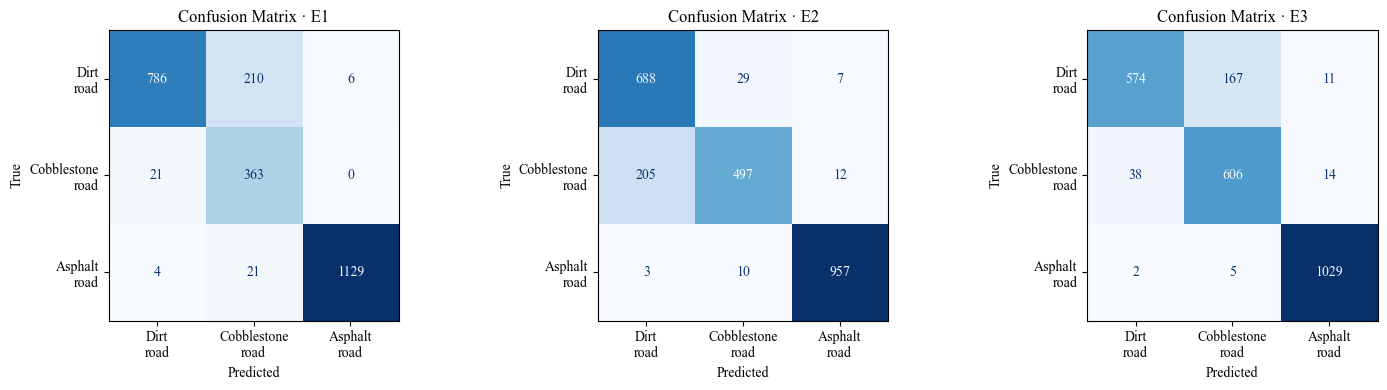

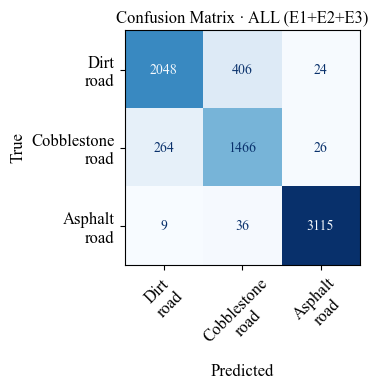

In [111]:
# Cell 11: Confusion matrices (per-exp và tổng)

LABEL_NAMES = ["Dirt\nroad", "Cobblestone\nroad", "Asphalt\nroad"]
CLASS_IDS   = [0, 1, 2]

exps = ["E1", "E2", "E3"]
y_tests, y_preds = {}, {}

# Tái huấn luyện + dự đoán trên test cho từng exp để vẽ CM
for exp in exps:
    print(f"[CM] Refit & predict on {exp}")
    X_train = globals()[f"train_features_{exp}"]
    y_train = np.asarray(globals()[f"label_train_{exp}"])
    X_test  = globals()[f"test_features_{exp}"]
    y_test  = np.asarray(globals()[f"label_test_{exp}"])

    clf = RandomForestClassifier(**BEST_PARAMS, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    y_tests[exp] = y_test
    y_preds[exp] = y_pred

# --- Hình 1: 1 hàng 3 cột (E1/E2/E3) ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, exp in enumerate(exps):
    ax = axes[idx]
    cm = confusion_matrix(y_tests[exp], y_preds[exp], labels=CLASS_IDS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix · {exp}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# --- Hình 2: Tổng (gộp E1+E2+E3) ---
y_all_true = np.concatenate([y_tests[e] for e in exps], axis=0)
y_all_pred = np.concatenate([y_preds[e] for e in exps], axis=0)
cm_all = confusion_matrix(y_all_true, y_all_pred, labels=CLASS_IDS)

fig2, ax2 = plt.subplots(1, 1, figsize=(4, 4))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=LABEL_NAMES)
disp_all.plot(ax=ax2, values_format='d', cmap="Blues", colorbar=False)
ax2.set_title("Confusion Matrix · ALL (E1+E2+E3)")
ax2.set_xlabel("Predicted", fontsize=12)
ax2.set_ylabel("True", fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()


## Cell 12 — Classification report

In [112]:
# Cell 12: Classification reports (per-exp và tổng)

exps = ["E1", "E2", "E3"]

# for exp in exps:
#     print(f"\n===== Classification Report · {exp} =====")
#     print(classification_report(
#         y_tests[exp],
#         y_preds[exp],
#         labels=[0,1,2],
#         target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
#         digits=4
#     ))

print("\n===== Classification Report · ALL (E1+E2+E3) =====")
print(classification_report(
    y_all_true,
    y_all_pred,
    labels=[0,1,2],
    target_names=["Dirt road", "Cobblestone road", "Asphalt road"],
    digits=4
))



===== Classification Report · ALL (E1+E2+E3) =====
                  precision    recall  f1-score   support

       Dirt road     0.8824    0.8265    0.8535      2478
Cobblestone road     0.7683    0.8349    0.8002      1756
    Asphalt road     0.9842    0.9858    0.9850      3160

        accuracy                         0.8965      7394
       macro avg     0.8783    0.8824    0.8796      7394
    weighted avg     0.8988    0.8965    0.8970      7394



## Cell 13 — Huấn luyện trên toàn bộ PVS và xuất mã C

In [113]:
# Cell 13: Huấn luyện trên toàn bộ PVS và xuất mã C

# Huấn luyện mô hình cuối cùng trên TOÀN BỘ dữ liệu
final_clf_RF = RandomForestClassifier(**BEST_PARAMS, random_state=42)
final_clf_RF.fit(X_all, y_all)

# Xuất mô hình sang header C/C++ bằng micromlgen
header_file = "micromlgen_PVS_RF.h"
temp_file_path = None

try:
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False, encoding="utf-8") as tmp:
        temp_file_path = tmp.name
        c_cpp_code = port(final_clf_RF, tmp_file=temp_file_path)

    with open(header_file, "w", encoding="utf-8") as f:
        f.write(c_cpp_code)

    size_bytes = os.path.getsize(header_file)
    size_kb = size_bytes / 1024
    size_mb = size_bytes / (1024 * 1024)
    print(f"✅ Exported to '{header_file}'")
    print(f"📦 Header size: {size_kb:.2f} KB ({size_mb:.3f} MB)")
except Exception as e:
    print(f"❌ Export error: {e}")
finally:
    if temp_file_path and os.path.exists(temp_file_path):
        os.remove(temp_file_path)
        print(f"🧹 Removed temp file: {temp_file_path}")


✅ Exported to 'micromlgen_PVS_RF.h'
📦 Header size: 1018.60 KB (0.995 MB)
🧹 Removed temp file: C:\Users\ADMINI~1\AppData\Local\Temp\2\tmp72jjn6e1.json
